# NYC Ferry Data Exploration & Visualization

**Comprehensive analysis of NYC Ferry ridership data (2017-2025) and private ferry operations (2013-2025)**

This notebook provides a thorough exploration of ferry transportation in the NYC metropolitan area, covering:

1. **Data Loading & Overview** - Understanding the datasets
2. **Data Quality Assessment** - Identifying issues and anomalies
3. **Temporal Patterns** - Hourly, daily, monthly, and yearly trends
4. **Route Analysis** - Performance by ferry route
5. **Stop Analysis** - Busiest terminals and geographic distribution
6. **Interactive Maps** - Visualizing ferry stops with basemaps
7. **Weekday vs Weekend** - Commuter vs recreational patterns
8. **Seasonal Analysis** - Summer vs winter ridership
9. **Growth Trends** - Year-over-year changes and COVID impact
10. **Private Ferry Comparison** - NYC Ferry vs NY Waterway vs others
11. **Cross-Modal Potential** - Ferry + Citi Bike connections

---

## Setup & Imports

In [1]:
# Core imports
import pandas as pd
import numpy as np
import duckdb
from pathlib import Path
import json
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Interactive maps
import folium
from folium.plugins import MarkerCluster, HeatMap

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Paths
FERRY_DIR = Path('../')
DATA_DIR = FERRY_DIR / 'data'
NYC_FERRY_PATH = DATA_DIR / 'nyc_ferry' / 'ridership.parquet'
PRIVATE_FERRY_PATH = DATA_DIR / 'private_ferry' / 'private_ferry_daily.parquet'
GTFS_DIR = DATA_DIR / 'gtfs' / 'nyc_ferry'

print(f"NYC Ferry data: {NYC_FERRY_PATH.exists()}")
print(f"Private ferry data: {PRIVATE_FERRY_PATH.exists()}")
print(f"GTFS data: {GTFS_DIR.exists()}")

NYC Ferry data: True
Private ferry data: True
GTFS data: True


/Users/davidpiegaro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


---

# Part 1: Data Loading & Overview

We have three main data sources:
1. **NYC Ferry ridership** - Hourly boardings by route/stop (2017-2025)
2. **Private ferry counts** - Daily ridership by operator/route (2013-2025)  
3. **GTFS reference data** - Stop locations and route definitions

## 1.1 NYC Ferry Ridership Data

In [2]:
# Load NYC Ferry data
nyc_ferry = pd.read_parquet(NYC_FERRY_PATH)

print("NYC Ferry Dataset")
print("="*60)
print(f"Total records: {len(nyc_ferry):,}")
print(f"Date range: {nyc_ferry['date'].min()} to {nyc_ferry['date'].max()}")
print(f"Total boardings: {nyc_ferry['boardings'].sum():,}")
print(f"\nColumns: {list(nyc_ferry.columns)}")
print(f"\nData types:")
print(nyc_ferry.dtypes)

NYC Ferry Dataset
Total records: 2,760,654
Date range: 2017-07-01 00:00:00 to 2025-10-31 00:00:00
Total boardings: 48,321,135

Columns: ['date', 'hour', 'route', 'direction', 'stop', 'boardings', 'typeday']

Data types:
date         datetime64[ns]
hour                  int64
route                object
direction            object
stop                 object
boardings             int64
typeday              object
dtype: object


In [3]:
# Sample of the data
print("\nSample records:")
nyc_ferry.sample(10)


Sample records:


,date,hour,route,direction,stop,boardings,typeday
1492942,2022-05-05,14,ER,SB,East 34th Street,72,Weekday
674803,2019-11-03,11,AS,SB,Long Island City,23,Weekend
1206337,2021-07-14,18,AS,SB,Roosevelt Island,36,Weekday
803923,2020-03-27,7,LE,NB,East 34th Street,0,Weekday
1900198,2023-06-04,8,AS,SB,Astoria,3,Weekend
2193866,2024-03-29,19,ER,SB,South Williamsburg,14,Weekday
432060,2019-02-22,8,SB,NB,Sunset Park/BAT,13,Weekday
2199195,2024-04-04,18,AS,NB,Brooklyn Navy Yard,29,Weekday
589925,2019-08-08,9,SV,NB,East 90th St,0,Weekday
42710,2017-09-14,13,SB,SB,Red Hook/Atlantic Basin,0,Weekday


In [4]:
# Basic statistics
print("Boardings Statistics:")
print(nyc_ferry['boardings'].describe())

Boardings Statistics:
count    2.760654e+06
mean     1.750351e+01
std      3.456964e+01
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+00
75%      1.900000e+01
max      1.334000e+03
Name: boardings, dtype: float64


In [5]:
# Unique values in categorical columns
print("\nUnique Routes:", nyc_ferry['route'].nunique())
print(nyc_ferry['route'].unique())

print("\nUnique Stops:", nyc_ferry['stop'].nunique())
print(sorted(nyc_ferry['stop'].unique()))

print("\nDirections:", nyc_ferry['direction'].unique())
print("\nDay types:", nyc_ferry['typeday'].unique())


Unique Routes: 9
['ER' 'RW' 'SB' 'AS' 'GI' 'SV' 'LE' 'SG' 'RR']

Unique Stops: 28
['Astoria', 'Atlantic Ave/BBP Pier 6', 'Battery Park City/Vesey St.', 'Bay Ridge', 'Brooklyn Navy Yard', 'Corlears Hook', 'Dumbo', 'Dumbo/BBP Pier 1', 'Dumbo/Fulton Ferry', 'East 34th Street', 'East 90th St', 'Ferry Point Park', 'Gov. Island/Yankee Pier', 'Governors Island', 'Greenpoint', 'Hunters Point South', 'Long Island City', 'Midtown West/W 39th St-Pier 79', 'North Williamsburg', 'Red Hook/Atlantic Basin', 'Rockaway', 'Roosevelt Island', 'Soundview', 'South Williamsburg', 'St. George', 'Stuyvesant Cove', 'Sunset Park/BAT', 'Wall St/Pier 11']

Directions: ['NB' 'SB' '(blank)']

Day types: ['Weekend' 'Weekday']


## 1.2 Private Ferry Data

In [6]:
# Load private ferry data
private_ferry = pd.read_parquet(PRIVATE_FERRY_PATH)

print("Private Ferry Dataset")
print("="*60)
print(f"Total records: {len(private_ferry):,}")
print(f"Date range: {private_ferry['date'].min()} to {private_ferry['date'].max()}")
print(f"Total ridership: {private_ferry['ridership'].sum():,}")
print(f"\nColumns: {list(private_ferry.columns)}")

Private Ferry Dataset
Total records: 252,369
Date range: 1900-01-01 to 2025-10-31
Total ridership: 137,625,733

Columns: ['date', 'day_of_week', 'holiday', 'operator', 'destination', 'origin', 'ridership']


In [7]:
# Operators in the dataset
print("\nFerry Operators:")
operator_stats = private_ferry.groupby('operator').agg({
    'ridership': 'sum',
    'date': ['min', 'max']
}).round(0)
operator_stats.columns = ['total_ridership', 'first_date', 'last_date']
operator_stats = operator_stats.sort_values('total_ridership', ascending=False)
operator_stats['pct'] = (operator_stats['total_ridership'] / operator_stats['total_ridership'].sum() * 100).round(1)
operator_stats


Ferry Operators:


,total_ridership,first_date,last_date,pct
operator,,,,
NY Waterway,59117204,2013-01-01,2025-10-31,43.0
NYC Ferry,30506140,1900-01-01,2025-10-31,22.2
Billy Bey,28084613,2013-01-01,2020-04-05,20.4
SeaStreak,12440169,2013-01-01,2025-10-31,9.0
Water Taxi,4622077,2013-01-01,2025-10-31,3.4
Liberty Landing,2341625,2013-01-01,2025-10-31,1.7
HMS,348137,2016-12-01,2017-05-02,0.3
Water Tours,144596,2017-03-01,2017-09-05,0.1
Baseball,21172,1900-01-01,2017-01-01,0.0


In [8]:
# Sample private ferry data
private_ferry.sample(10)

,date,day_of_week,holiday,operator,destination,origin,ridership
102559,2019-10-05,Saturday,None,NY Waterway,Pier 79,Weehawken Midtown,8998
164834,2022-10-02,Sunday,None,NYC Ferry,Astoria,Astoria,269
2241,2013-03-07,Thursday,None,Billy Bey,Atlantic Ave,East River,0
186647,2023-07-05,Wednesday,None,SeaStreak,East 34th Street,Highlands,961
97288,2019-07-06,,None,Water Taxi,All Day Access Pass (ADAP),Pier 16 / South Street Seaport,0
141550,2021-11-12,Friday,None,NYC Ferry,Astoria,Long Island City,467
216227,2024-09-17,Tuesday,None,NYC Ferry,Soundview,Ferry Point Park,363
166871,2022-11-22,Tuesday,None,NYC Ferry,Soundview,Wall St Pier 11,410
111140,2020-04-02,Thursday,None,Billy Bey,Slip 5,Port Liberte,0
173974,2023-02-11,Sunday,None,NYC Ferry,Governor's Island,Yankee Pier,0


## 1.3 GTFS Reference Data (Stop Locations)

In [9]:
# Load GTFS stops
stops = pd.read_csv(GTFS_DIR / 'stops.txt')
routes = pd.read_csv(GTFS_DIR / 'routes.txt')

print("GTFS Stops")
print("="*60)
print(f"Total stops: {len(stops)}")
print(f"\nColumns: {list(stops.columns)}")
stops.head(10)

GTFS Stops
Total stops: 51

Columns: ['stop_id', 'stop_code', 'stop_name', 'stop_lat', 'stop_lon', 'location_type', 'parent_station']


,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station
0,4,2319806.0,Hunters Point South,40.741838,-73.961322,NaN,NaN
1,8,2319809.0,South Williamsburg,40.708743,-73.970224,NaN,NaN
2,11,2319817.0,Atlantic Ave/BBP Pier 6,40.692315,-74.002073,NaN,NaN
3,16,2319821.0,Beach Channel Dr/Beach 108th Street,40.583846,-73.831658,NaN,NaN
4,17,2319805.0,East 34th Street,40.743912,-73.970731,NaN,NaN
5,18,2319807.0,Greenpoint,40.731365,-73.963617,NaN,NaN
6,19,2319808.0,North Williamsburg,40.720838,-73.964902,NaN,NaN
7,20,2319810.0,Dumbo/Fulton Ferry,40.703652,-73.995671,NaN,NaN
8,23,2319815.0,Bay Ridge,40.639858,-74.038130,NaN,NaN
9,24,2319816.0,Red Hook/Atlantic Basin,40.680957,-74.013358,NaN,NaN


In [10]:
# GTFS Routes
print("GTFS Routes")
print("="*60)
routes[['route_id', 'route_long_name', 'route_color']]

GTFS Routes


,route_id,route_long_name,route_color
0,AS,Astoria,FF6B00
1,ER,East River,00839C
2,RES,Rockaway East,00A1E1
3,RS,Rockaway-Soundview,4E008E
4,RW,Rockaway,B218AA
5,RWS,Rockaway West,00A1E1
6,SB,South Brooklyn,FFD100
7,SG,St. George,D0006F


In [11]:
# Create a route name mapping
route_names = {
    'ER': 'East River',
    'AS': 'Astoria', 
    'SB': 'South Brooklyn',
    'RW': 'Rockaway',
    'SV': 'Soundview',
    'SG': 'St. George',
    'LE': 'Lower East Side',
    'GI': 'Governors Island',
    'RR': 'Rockaway Rocket'
}

route_colors = {
    'ER': '#00839C',
    'AS': '#FF6B00',
    'SB': '#FFD100',
    'RW': '#B218AA',
    'SV': '#4E008E',
    'SG': '#D0006F',
    'LE': '#00A1E1',
    'GI': '#228B22',
    'RR': '#00A1E1'
}

---

# Part 2: Data Quality Assessment

Understanding data quality issues is critical before analysis.

## 2.1 Zero Boardings Issue

In [12]:
# Analyze zero boardings
zero_boardings = nyc_ferry[nyc_ferry['boardings'] == 0]
nonzero_boardings = nyc_ferry[nyc_ferry['boardings'] > 0]

print("CRITICAL DATA QUALITY ISSUE: Zero Boardings")
print("="*60)
print(f"Total records: {len(nyc_ferry):,}")
print(f"Zero boardings: {len(zero_boardings):,} ({len(zero_boardings)/len(nyc_ferry)*100:.1f}%)")
print(f"Non-zero boardings: {len(nonzero_boardings):,} ({len(nonzero_boardings)/len(nyc_ferry)*100:.1f}%)")

CRITICAL DATA QUALITY ISSUE: Zero Boardings
Total records: 2,760,654
Zero boardings: 822,678 (29.8%)
Non-zero boardings: 1,937,976 (70.2%)


In [13]:
# Zero boardings by route
zero_by_route = nyc_ferry.groupby('route').apply(
    lambda x: pd.Series({
        'total_records': len(x),
        'zero_records': (x['boardings'] == 0).sum(),
        'zero_pct': (x['boardings'] == 0).mean() * 100
    })
).round(1)

print("\nZero Boardings by Route:")
zero_by_route.sort_values('zero_pct', ascending=False)


Zero Boardings by Route:


/var/folders/zg/24spslbs27j5my7jcb93qhkc0000gn/T/ipykernel_68325/1199456453.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zero_by_route = nyc_ferry.groupby('route').apply(


,total_records,zero_records,zero_pct
route,,,
RR,947.0,568.0,60.0
GI,13094.0,7388.0,56.4
LE,92459.0,37451.0,40.5
RW,269711.0,106852.0,39.6
SB,614303.0,236213.0,38.5
SG,135924.0,50279.0,37.0
SV,416447.0,130294.0,31.3
AS,577136.0,127456.0,22.1
ER,640633.0,126177.0,19.7


/var/folders/zg/24spslbs27j5my7jcb93qhkc0000gn/T/ipykernel_68325/935860565.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zero_by_hour = nyc_ferry.groupby('hour').apply(


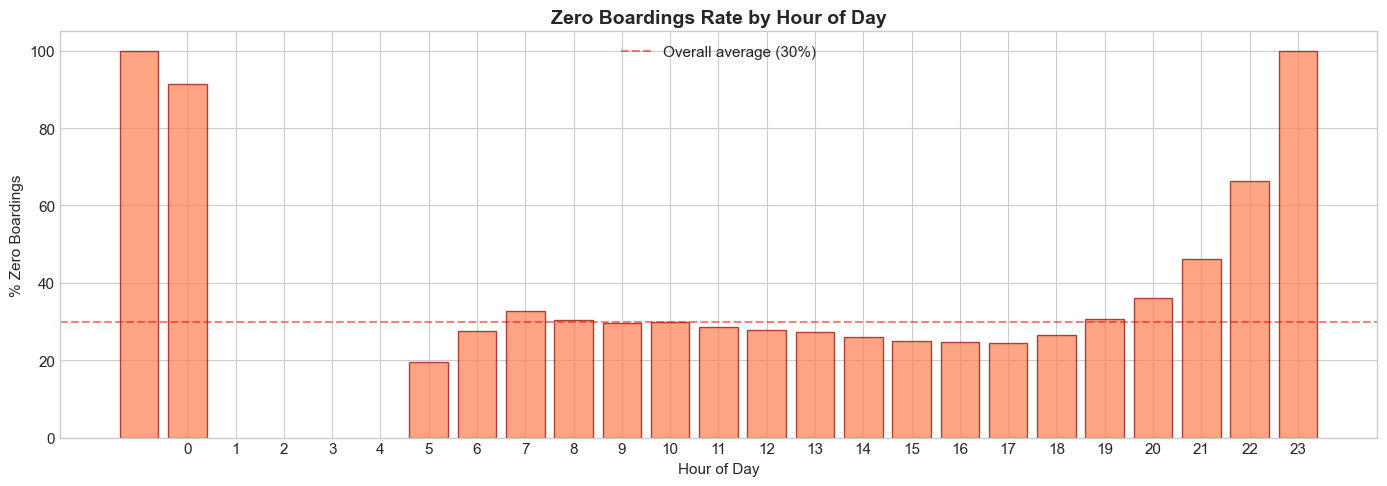


Observation: Early morning hours (4-6 AM) have higher zero rates,
likely representing scheduled but empty early ferries.


In [14]:
# Zero boardings by hour
zero_by_hour = nyc_ferry.groupby('hour').apply(
    lambda x: (x['boardings'] == 0).mean() * 100
).round(1)

fig, ax = plt.subplots(figsize=(14, 5))
bars = ax.bar(zero_by_hour.index, zero_by_hour.values, color='coral', edgecolor='darkred', alpha=0.7)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('% Zero Boardings')
ax.set_title('Zero Boardings Rate by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xticks(range(24))
ax.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='Overall average (30%)')
ax.legend()
plt.tight_layout()
plt.show()

print("\nObservation: Early morning hours (4-6 AM) have higher zero rates,")
print("likely representing scheduled but empty early ferries.")

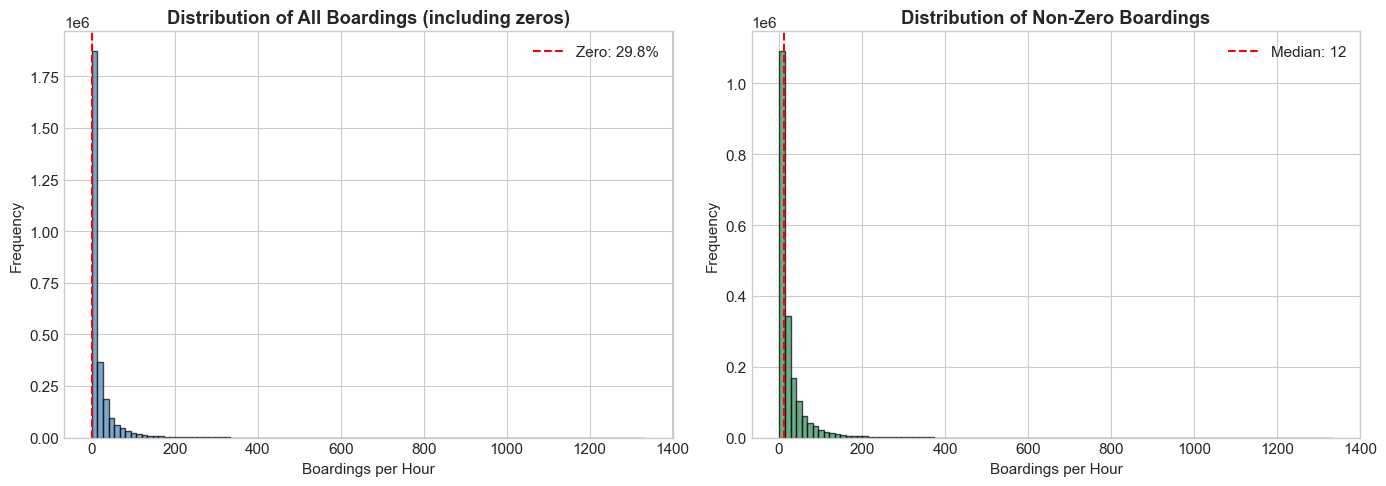

In [15]:
# Visualize the distribution of boardings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All data
axes[0].hist(nyc_ferry['boardings'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Boardings per Hour')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Boardings (including zeros)', fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', label=f'Zero: {len(zero_boardings)/len(nyc_ferry)*100:.1f}%')
axes[0].legend()

# Non-zero only
axes[1].hist(nonzero_boardings['boardings'], bins=100, color='seagreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Boardings per Hour')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Non-Zero Boardings', fontweight='bold')
median_val = nonzero_boardings['boardings'].median()
axes[1].axvline(x=median_val, color='red', linestyle='--', label=f'Median: {median_val:.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 2.2 Missing Values & Invalid Data

In [16]:
# Check for missing values
print("Missing Values in NYC Ferry Data:")
print(nyc_ferry.isnull().sum())

# Check for invalid hours
print(f"\nHour range: {nyc_ferry['hour'].min()} to {nyc_ferry['hour'].max()}")
invalid_hours = nyc_ferry[(nyc_ferry['hour'] < 0) | (nyc_ferry['hour'] > 23)]
print(f"Invalid hours (outside 0-23): {len(invalid_hours)}")

Missing Values in NYC Ferry Data:
date         0
hour         0
route        0
direction    0
stop         0
boardings    0
typeday      0
dtype: int64

Hour range: -1 to 23
Invalid hours (outside 0-23): 56


In [17]:
# Check date continuity
dates = pd.to_datetime(nyc_ferry['date']).dt.date.unique()
dates = sorted(dates)
date_range = pd.date_range(start=min(dates), end=max(dates), freq='D')

missing_dates = set(date_range.date) - set(dates)
print(f"Date Coverage:")
print(f"First date: {min(dates)}")
print(f"Last date: {max(dates)}")
print(f"Expected days: {len(date_range)}")
print(f"Actual days: {len(dates)}")
print(f"Missing days: {len(missing_dates)}")

if missing_dates:
    print(f"\nMissing dates: {sorted(list(missing_dates))[:10]}..." if len(missing_dates) > 10 else f"\nMissing dates: {sorted(list(missing_dates))}")

Date Coverage:
First date: 2017-07-01
Last date: 2025-10-31
Expected days: 3045
Actual days: 3044
Missing days: 1

Missing dates: [datetime.date(2021, 2, 1)]


## 2.3 Create Clean Dataset

In [18]:
# Create a clean version filtering out zero boardings for ridership analysis
ferry_clean = nyc_ferry[nyc_ferry['boardings'] > 0].copy()

# Add derived columns
ferry_clean['date'] = pd.to_datetime(ferry_clean['date'])
ferry_clean['year'] = ferry_clean['date'].dt.year
ferry_clean['month'] = ferry_clean['date'].dt.month
ferry_clean['day_of_week'] = ferry_clean['date'].dt.dayofweek
ferry_clean['day_name'] = ferry_clean['date'].dt.day_name()
ferry_clean['is_weekend'] = ferry_clean['day_of_week'] >= 5
ferry_clean['route_name'] = ferry_clean['route'].map(route_names)

# Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

ferry_clean['season'] = ferry_clean['month'].apply(get_season)

# Time period
def get_time_period(hour):
    if 5 <= hour < 7:
        return 'Early Morning'
    elif 7 <= hour < 10:
        return 'AM Rush'
    elif 10 <= hour < 16:
        return 'Midday'
    elif 16 <= hour < 19:
        return 'PM Rush'
    elif 19 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

ferry_clean['time_period'] = ferry_clean['hour'].apply(get_time_period)

print(f"Clean dataset: {len(ferry_clean):,} records (filtered {len(nyc_ferry) - len(ferry_clean):,} zero-boarding records)")
print(f"Total boardings: {ferry_clean['boardings'].sum():,}")
ferry_clean.head()

Clean dataset: 1,937,976 records (filtered 822,678 zero-boarding records)
Total boardings: 48,321,135


,date,hour,route,direction,stop,boardings,typeday,year,month,day_of_week,day_name,is_weekend,route_name,season,time_period
4,2017-07-01,8,ER,SB,Dumbo/BBP Pier 1,4,Weekend,2017,7,5,Saturday,True,East River,Summer,AM Rush
5,2017-07-01,8,ER,NB,Dumbo/BBP Pier 1,4,Weekend,2017,7,5,Saturday,True,East River,Summer,AM Rush
6,2017-07-01,9,ER,SB,Dumbo/BBP Pier 1,16,Weekend,2017,7,5,Saturday,True,East River,Summer,AM Rush
7,2017-07-01,9,ER,NB,Dumbo/BBP Pier 1,10,Weekend,2017,7,5,Saturday,True,East River,Summer,AM Rush
8,2017-07-01,10,ER,SB,Dumbo/BBP Pier 1,17,Weekend,2017,7,5,Saturday,True,East River,Summer,Midday


---

# Part 3: Temporal Patterns

Understanding when people ride ferries reveals commuter vs recreational usage.

## 3.1 Hourly Patterns

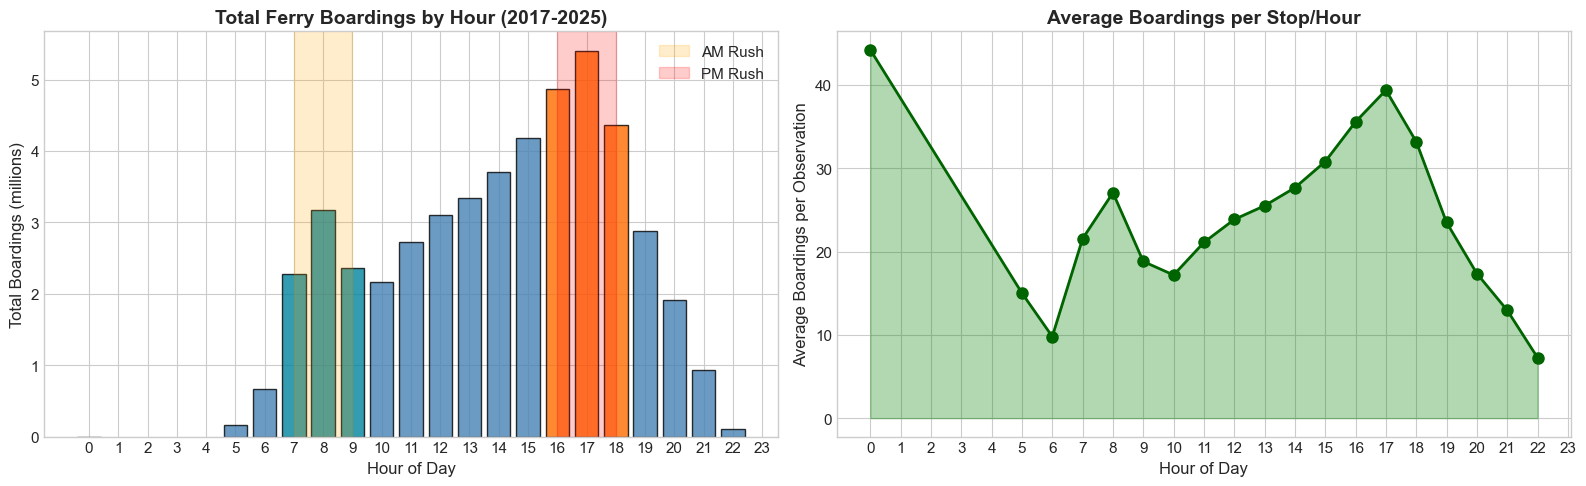


Key Finding: PM Rush (4-6 PM) dominates ferry ridership!
This suggests ferries are primarily used for return commutes from Manhattan.


In [19]:
# Hourly ridership totals
hourly = ferry_clean.groupby('hour')['boardings'].agg(['sum', 'mean', 'count']).reset_index()
hourly.columns = ['hour', 'total_boardings', 'avg_boardings', 'observations']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Total boardings by hour
colors = ['#FF6B00' if 16 <= h <= 18 else '#00839C' if 7 <= h <= 9 else 'steelblue' for h in hourly['hour']]
axes[0].bar(hourly['hour'], hourly['total_boardings']/1e6, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Total Boardings (millions)', fontsize=12)
axes[0].set_title('Total Ferry Boardings by Hour (2017-2025)', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(24))
axes[0].axvspan(7, 9, alpha=0.2, color='orange', label='AM Rush')
axes[0].axvspan(16, 18, alpha=0.2, color='red', label='PM Rush')
axes[0].legend()

# Average boardings per observation
axes[1].plot(hourly['hour'], hourly['avg_boardings'], marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].fill_between(hourly['hour'], hourly['avg_boardings'], alpha=0.3, color='green')
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Average Boardings per Observation', fontsize=12)
axes[1].set_title('Average Boardings per Stop/Hour', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(24))

plt.tight_layout()
plt.show()

print("\nKey Finding: PM Rush (4-6 PM) dominates ferry ridership!")
print("This suggests ferries are primarily used for return commutes from Manhattan.")

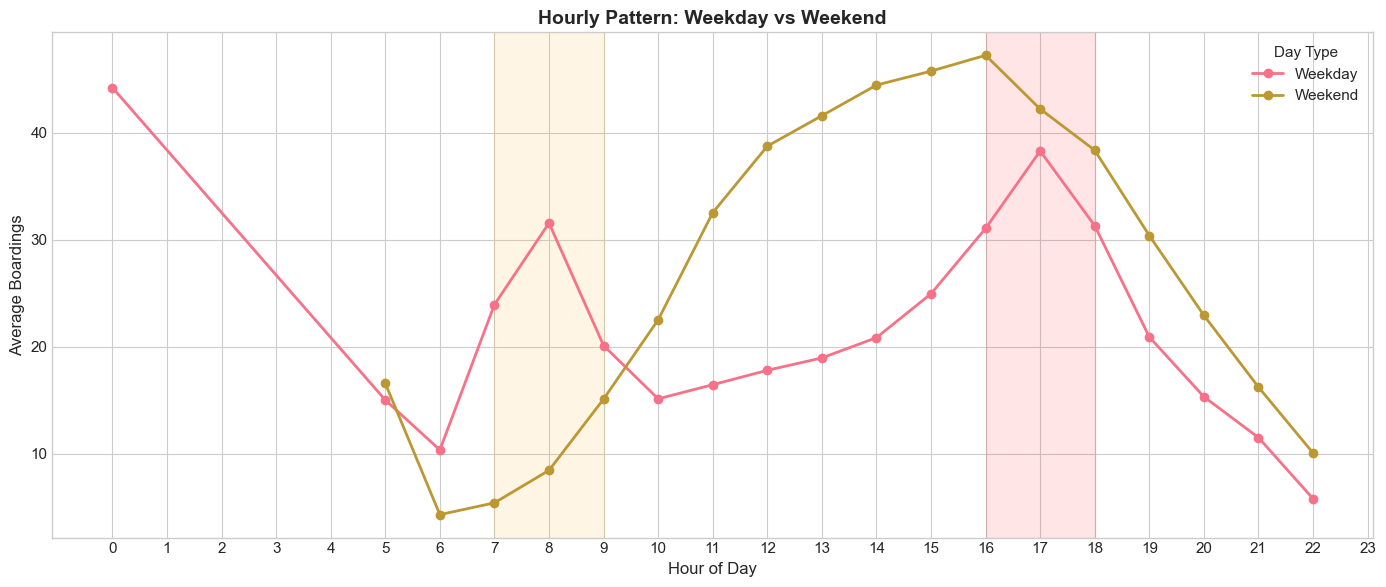


Weekends have HIGHER average boardings per observation!
This likely reflects: (1) fewer scheduled trips, (2) more crowded boats, (3) tourist demand


In [20]:
# Hourly pattern by day type
hourly_by_daytype = ferry_clean.groupby(['hour', 'typeday'])['boardings'].mean().unstack()

fig, ax = plt.subplots(figsize=(14, 6))
hourly_by_daytype.plot(ax=ax, marker='o', linewidth=2, markersize=6)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Average Boardings', fontsize=12)
ax.set_title('Hourly Pattern: Weekday vs Weekend', fontsize=14, fontweight='bold')
ax.set_xticks(range(24))
ax.legend(title='Day Type')
ax.axvspan(7, 9, alpha=0.1, color='orange')
ax.axvspan(16, 18, alpha=0.1, color='red')
plt.tight_layout()
plt.show()

print("\nWeekends have HIGHER average boardings per observation!")
print("This likely reflects: (1) fewer scheduled trips, (2) more crowded boats, (3) tourist demand")

## 3.2 Daily Patterns (Day of Week)

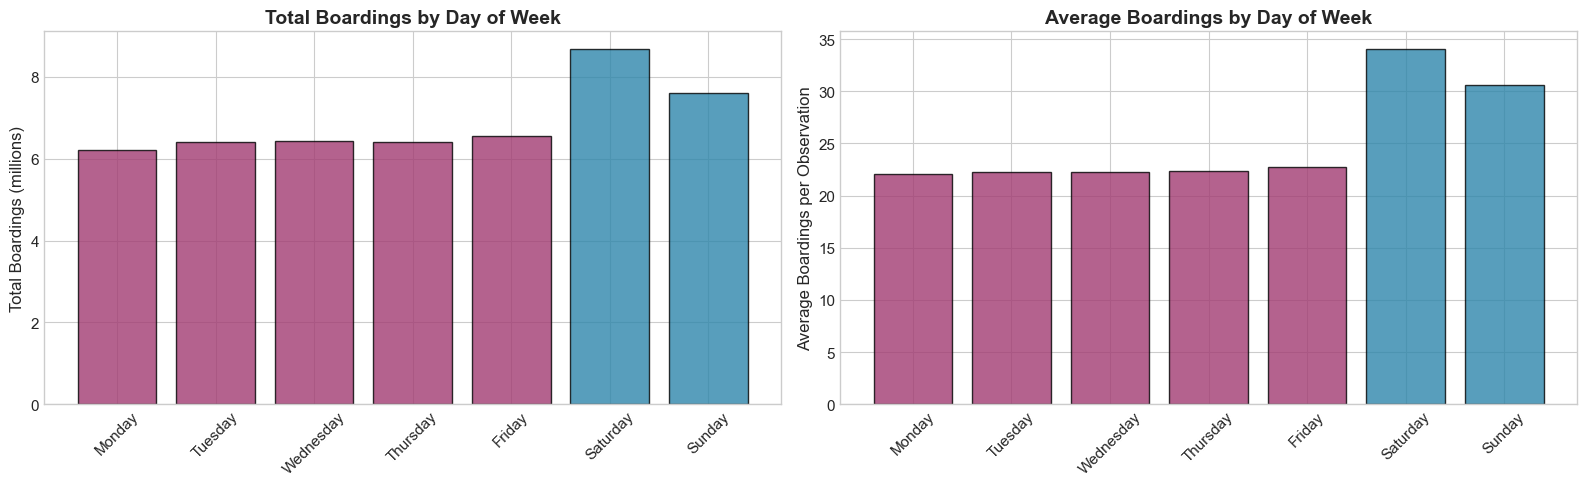


Interesting: Total ridership is higher on weekdays, but AVERAGE is higher on weekends.
This confirms weekday commuter service runs more frequently with smaller loads per trip.


In [21]:
# Day of week pattern
daily = ferry_clean.groupby('day_name')['boardings'].agg(['sum', 'mean']).reset_index()
daily.columns = ['day', 'total', 'average']

# Order days correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily['day'] = pd.Categorical(daily['day'], categories=day_order, ordered=True)
daily = daily.sort_values('day')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Total by day
colors = ['#2E86AB' if d in ['Saturday', 'Sunday'] else '#A23B72' for d in daily['day']]
axes[0].bar(daily['day'], daily['total']/1e6, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_ylabel('Total Boardings (millions)', fontsize=12)
axes[0].set_title('Total Boardings by Day of Week', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Average by day
axes[1].bar(daily['day'], daily['average'], color=colors, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('Average Boardings per Observation', fontsize=12)
axes[1].set_title('Average Boardings by Day of Week', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nInteresting: Total ridership is higher on weekdays, but AVERAGE is higher on weekends.")
print("This confirms weekday commuter service runs more frequently with smaller loads per trip.")

## 3.3 Monthly Patterns

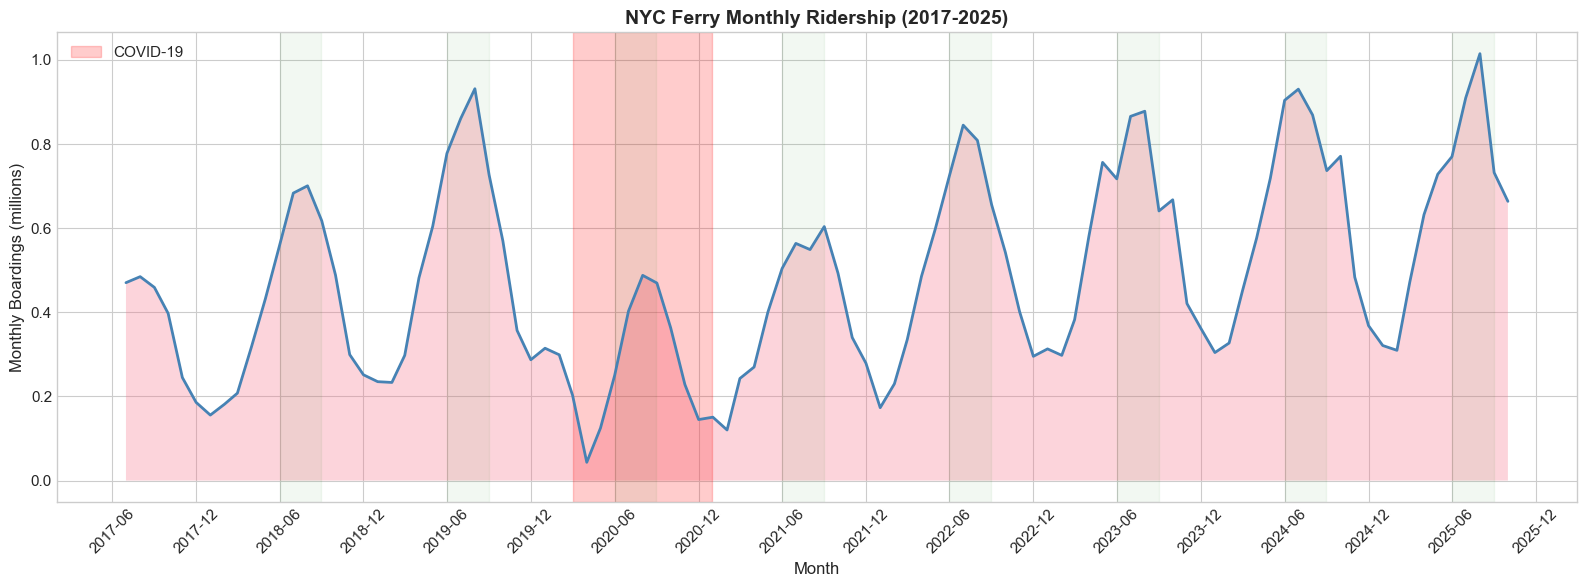


Highest month: 2025-08 - 1,014,828 boardings
Lowest month (post-launch): 2020-04-01T00:00:00.000000000 - 43,416 boardings


In [22]:
# Monthly ridership
monthly = ferry_clean.groupby([ferry_clean['date'].dt.to_period('M')])['boardings'].sum().reset_index()
monthly.columns = ['month', 'boardings']
monthly['month'] = monthly['month'].dt.to_timestamp()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(monthly['month'], monthly['boardings']/1e6, linewidth=2, color='steelblue')
ax.fill_between(monthly['month'], monthly['boardings']/1e6, alpha=0.3)

# Mark COVID period
ax.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-12-31'), alpha=0.2, color='red', label='COVID-19')

# Mark summer peaks
for year in range(2018, 2026):
    ax.axvspan(pd.Timestamp(f'{year}-06-01'), pd.Timestamp(f'{year}-08-31'), alpha=0.05, color='green')

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Boardings (millions)', fontsize=12)
ax.set_title('NYC Ferry Monthly Ridership (2017-2025)', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# Find peaks and troughs
print(f"\nHighest month: {monthly.loc[monthly['boardings'].idxmax(), 'month'].strftime('%Y-%m')} - {monthly['boardings'].max():,.0f} boardings")
print(f"Lowest month (post-launch): {monthly[monthly['month'] > '2017-12'].nsmallest(1, 'boardings')['month'].values[0]} - {monthly[monthly['month'] > '2017-12']['boardings'].min():,.0f} boardings")

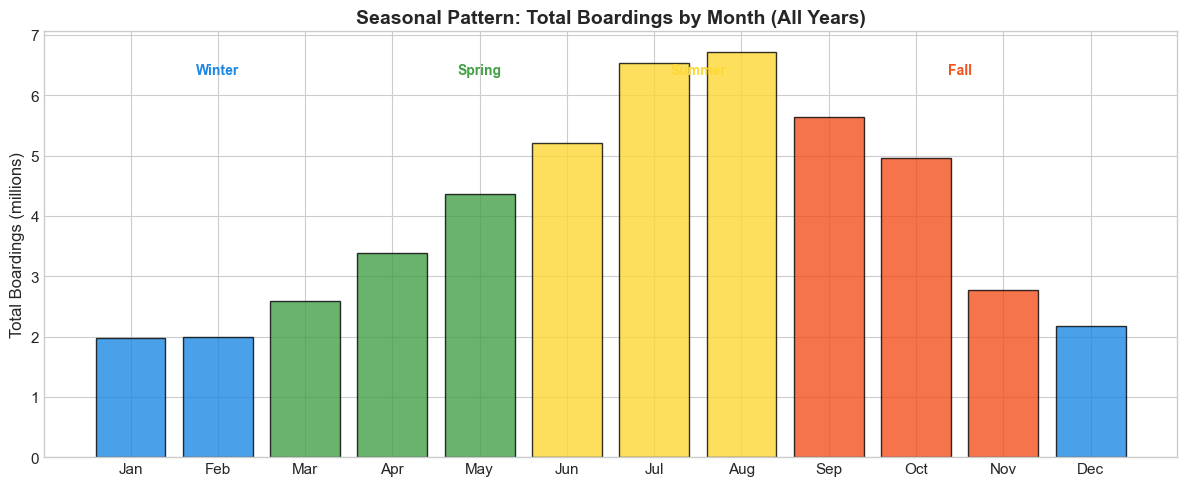


Summer months (June-August) have 2-3x the ridership of winter months!


In [23]:
# Seasonality - average by month across all years
month_avg = ferry_clean.groupby('month')['boardings'].sum().reset_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['#1E88E5' if m in [12, 1, 2] else '#43A047' if m in [3, 4, 5] else '#FDD835' if m in [6, 7, 8] else '#F4511E' for m in month_avg['month']]
ax.bar(month_avg['month'], month_avg['boardings']/1e6, color=colors, edgecolor='black', alpha=0.8)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.set_ylabel('Total Boardings (millions)', fontsize=12)
ax.set_title('Seasonal Pattern: Total Boardings by Month (All Years)', fontsize=14, fontweight='bold')

# Add season labels
ax.text(2, ax.get_ylim()[1]*0.9, 'Winter', ha='center', fontsize=10, color='#1E88E5', fontweight='bold')
ax.text(5, ax.get_ylim()[1]*0.9, 'Spring', ha='center', fontsize=10, color='#43A047', fontweight='bold')
ax.text(7.5, ax.get_ylim()[1]*0.9, 'Summer', ha='center', fontsize=10, color='#FDD835', fontweight='bold')
ax.text(10.5, ax.get_ylim()[1]*0.9, 'Fall', ha='center', fontsize=10, color='#F4511E', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSummer months (June-August) have 2-3x the ridership of winter months!")

## 3.4 Yearly Trends

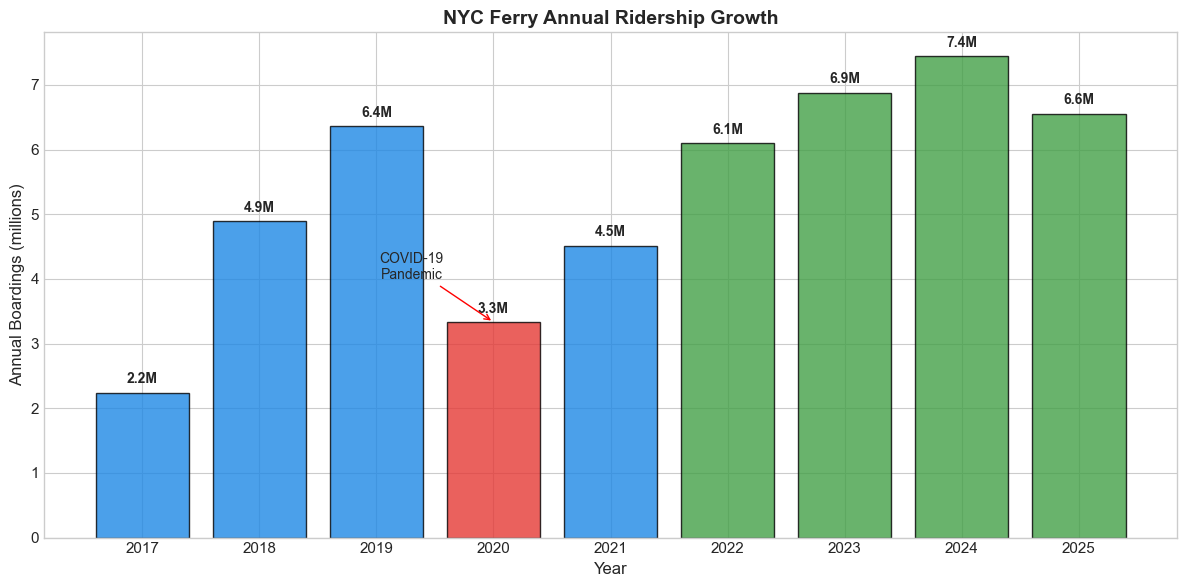


Year-over-Year Growth:
2018: +118.3%
2019: +30.0%
2020: -47.6%
2021: +35.5%
2022: +35.0%
2023: +12.9%
2024: +8.1%
2025: -11.9%


In [24]:
# Annual ridership
yearly = ferry_clean.groupby('year')['boardings'].sum().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#E53935' if y == 2020 else '#43A047' if y >= 2022 else '#1E88E5' for y in yearly['year']]
bars = ax.bar(yearly['year'], yearly['boardings']/1e6, color=colors, edgecolor='black', alpha=0.8)

# Add value labels
for bar, val in zip(bars, yearly['boardings']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val/1e6:.1f}M', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annual Boardings (millions)', fontsize=12)
ax.set_title('NYC Ferry Annual Ridership Growth', fontsize=14, fontweight='bold')
ax.set_xticks(yearly['year'])

# Add annotations
ax.annotate('COVID-19\nPandemic', xy=(2020, yearly[yearly['year']==2020]['boardings'].values[0]/1e6),
            xytext=(2019.3, 4), fontsize=10, ha='center',
            arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

# Calculate YoY growth
yearly['yoy_growth'] = yearly['boardings'].pct_change() * 100
print("\nYear-over-Year Growth:")
for _, row in yearly.iterrows():
    if pd.notna(row['yoy_growth']):
        print(f"{int(row['year'])}: {row['yoy_growth']:+.1f}%")

## 3.5 Heatmap: Hour x Day of Week

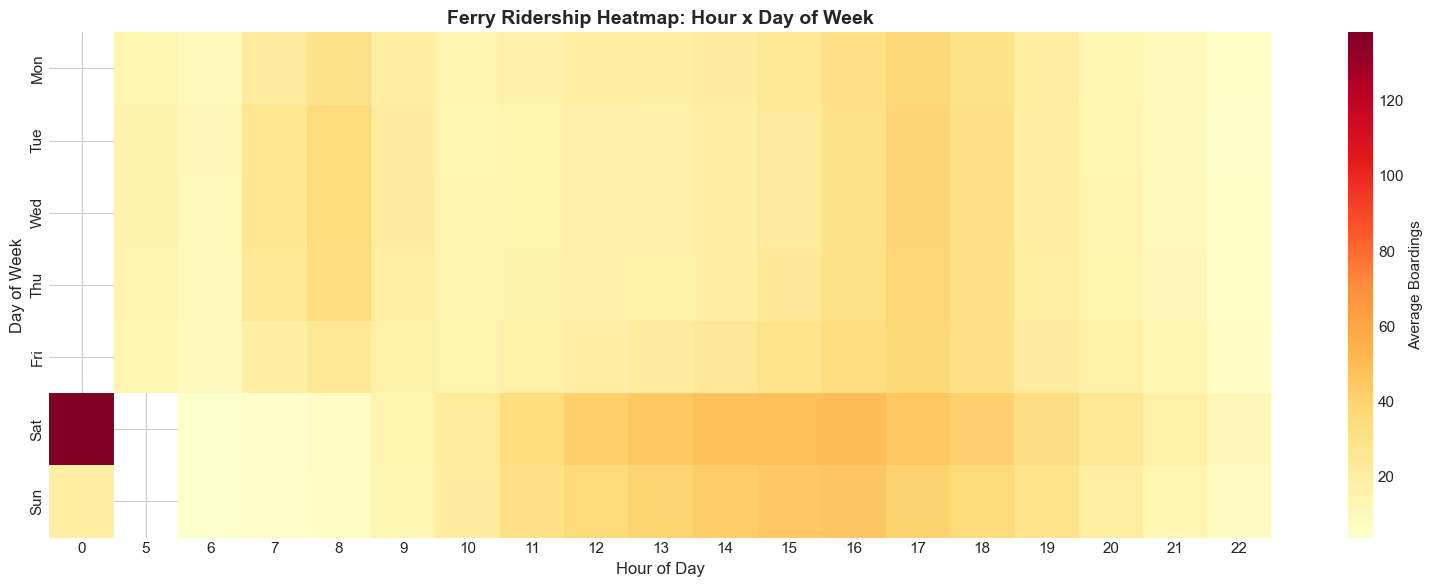


Pattern: Weekend afternoons (especially Saturdays) show strong ridership.
Weekday PM rush (4-6 PM) is the dominant commuter window.


In [25]:
# Create heatmap of hour x day of week
heatmap_data = ferry_clean.groupby(['day_of_week', 'hour'])['boardings'].mean().unstack()
heatmap_data.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, fmt='.0f', 
            cbar_kws={'label': 'Average Boardings'}, ax=ax)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_title('Ferry Ridership Heatmap: Hour x Day of Week', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nPattern: Weekend afternoons (especially Saturdays) show strong ridership.")
print("Weekday PM rush (4-6 PM) is the dominant commuter window.")

---

# Part 4: Route Analysis

Which routes carry the most passengers? Which are growing fastest?

In [26]:
# Route summary
route_summary = ferry_clean.groupby('route').agg({
    'boardings': ['sum', 'mean', 'max'],
    'date': ['min', 'max']
}).round(1)
route_summary.columns = ['total_boardings', 'avg_boardings', 'max_boardings', 'first_date', 'last_date']
route_summary = route_summary.sort_values('total_boardings', ascending=False)
route_summary['pct_total'] = (route_summary['total_boardings'] / route_summary['total_boardings'].sum() * 100).round(1)
route_summary['route_name'] = route_summary.index.map(route_names)

print("Route Performance Summary:")
route_summary

Route Performance Summary:


,total_boardings,avg_boardings,max_boardings,first_date,last_date,pct_total,route_name
route,,,,,,,
ER,18539609,36.0,1334,2017-07-01,2025-10-31,38.4,East River
AS,9779835,21.7,598,2017-08-29,2025-10-31,20.2,Astoria
SB,5708527,15.1,544,2017-07-01,2025-10-31,11.8,South Brooklyn
RW,5701038,35.0,1152,2017-07-01,2025-10-31,11.8,Rockaway
SV,5272060,18.4,524,2018-08-15,2025-10-31,10.9,Soundview
SG,2230655,26.0,370,2021-08-23,2025-10-31,4.6,St. George
LE,563882,10.3,214,2018-08-29,2020-05-17,1.2,Lower East Side
GI,483794,84.8,692,2018-06-30,2025-10-13,1.0,Governors Island
RR,41735,110.1,314,2022-07-23,2025-09-01,0.1,Rockaway Rocket


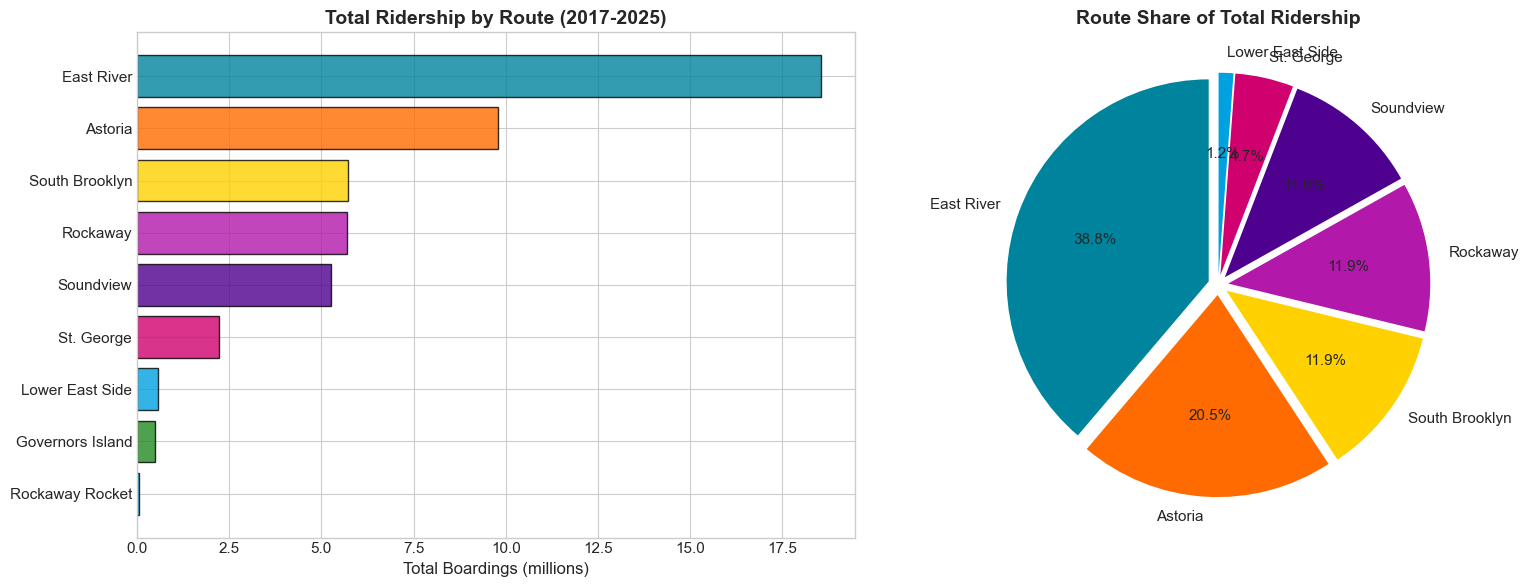

In [27]:
# Visualize route ridership
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
route_data = route_summary.reset_index().sort_values('total_boardings', ascending=True)
colors = [route_colors.get(r, '#808080') for r in route_data['route']]
axes[0].barh(route_data['route_name'], route_data['total_boardings']/1e6, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Total Boardings (millions)', fontsize=12)
axes[0].set_title('Total Ridership by Route (2017-2025)', fontsize=14, fontweight='bold')

# Pie chart
route_pie = route_summary[route_summary['pct_total'] > 1].copy()  # Routes > 1%
pie_colors = [route_colors.get(r, '#808080') for r in route_pie.index]
axes[1].pie(route_pie['total_boardings'], labels=route_pie['route_name'], colors=pie_colors,
            autopct='%1.1f%%', startangle=90, explode=[0.05]*len(route_pie))
axes[1].set_title('Route Share of Total Ridership', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

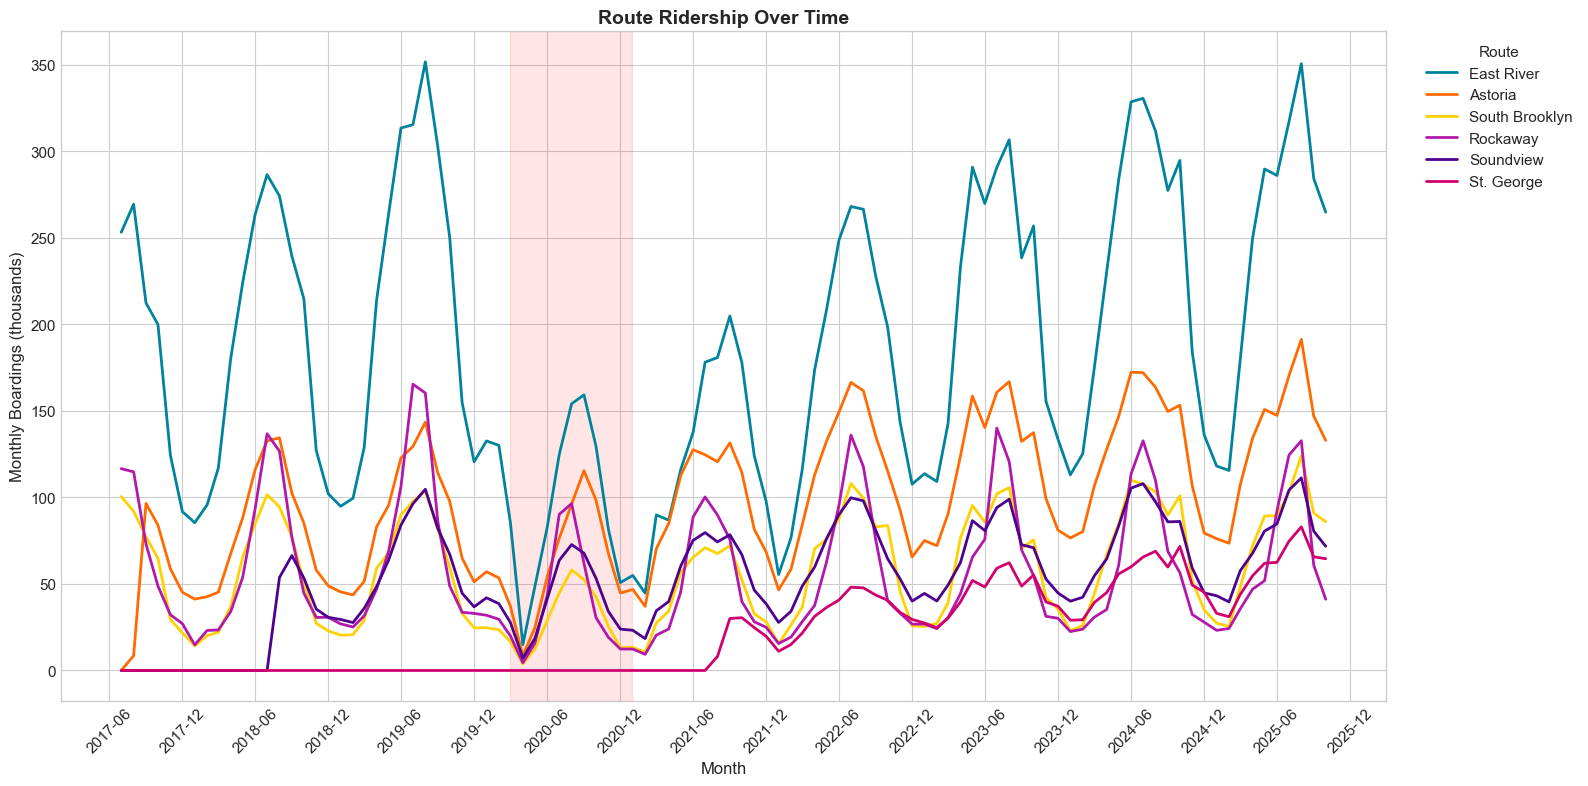

In [28]:
# Route ridership over time
route_monthly = ferry_clean.groupby([ferry_clean['date'].dt.to_period('M'), 'route'])['boardings'].sum().unstack(fill_value=0)
route_monthly.index = route_monthly.index.to_timestamp()

fig, ax = plt.subplots(figsize=(16, 8))

for route in ['ER', 'AS', 'SB', 'RW', 'SV', 'SG']:
    if route in route_monthly.columns:
        ax.plot(route_monthly.index, route_monthly[route]/1e3, 
                label=route_names.get(route, route), 
                color=route_colors.get(route, '#808080'),
                linewidth=2)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Boardings (thousands)', fontsize=12)
ax.set_title('Route Ridership Over Time', fontsize=14, fontweight='bold')
ax.legend(title='Route', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

# Mark COVID
ax.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-12-31'), alpha=0.1, color='red')

plt.tight_layout()
plt.show()

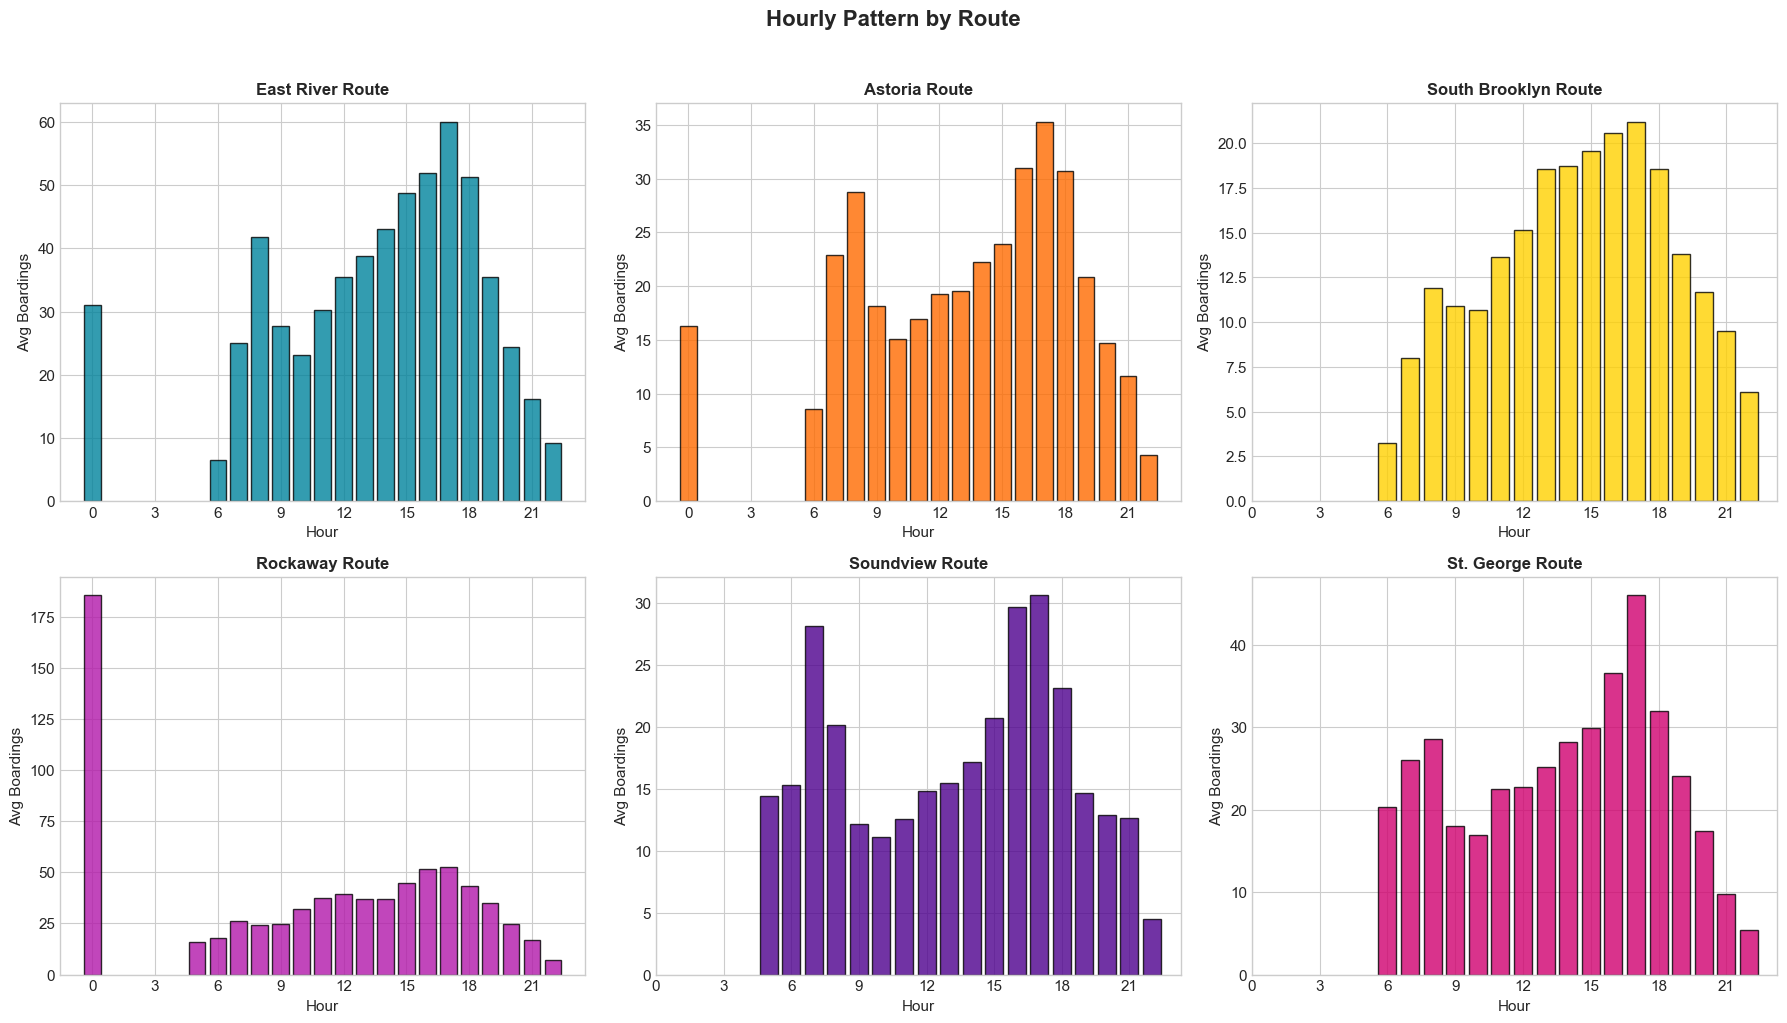


Observations:
- East River: Strong PM rush, serving commuters
- Rockaway: Afternoon peak, recreational/beach traffic
- Astoria: Double peak (AM and PM rush)


In [29]:
# Route hourly patterns
route_hourly = ferry_clean.groupby(['route', 'hour'])['boardings'].mean().unstack()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, route in enumerate(['ER', 'AS', 'SB', 'RW', 'SV', 'SG']):
    if route in route_hourly.index:
        ax = axes[idx]
        data = route_hourly.loc[route]
        ax.bar(data.index, data.values, color=route_colors.get(route, '#808080'), alpha=0.8, edgecolor='black')
        ax.set_title(f'{route_names.get(route, route)} Route', fontsize=12, fontweight='bold')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Avg Boardings')
        ax.set_xticks(range(0, 24, 3))

plt.suptitle('Hourly Pattern by Route', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- East River: Strong PM rush, serving commuters")
print("- Rockaway: Afternoon peak, recreational/beach traffic")
print("- Astoria: Double peak (AM and PM rush)")

---

# Part 5: Stop Analysis

Which terminals are busiest? What's the geographic distribution?

In [30]:
# Stop summary
stop_summary = ferry_clean.groupby('stop').agg({
    'boardings': ['sum', 'mean', 'count']
}).round(1)
stop_summary.columns = ['total_boardings', 'avg_boardings', 'observations']
stop_summary = stop_summary.sort_values('total_boardings', ascending=False)
stop_summary['pct_total'] = (stop_summary['total_boardings'] / stop_summary['total_boardings'].sum() * 100).round(1)
stop_summary['cumulative_pct'] = stop_summary['pct_total'].cumsum()

print("Top 15 Busiest Ferry Stops:")
stop_summary.head(15)

Top 15 Busiest Ferry Stops:


,total_boardings,avg_boardings,observations,pct_total,cumulative_pct
stop,,,,,
Wall St/Pier 11,10802133,44.3,243933,22.4,22.4
East 34th Street,6497418,26.8,242537,13.4,35.8
North Williamsburg,3259083,35.1,92728,6.7,42.5
Dumbo/Fulton Ferry,2597466,35.8,72591,5.4,47.9
Rockaway,2548512,55.8,45645,5.3,53.2
East 90th St,1988875,20.6,96762,4.1,57.3
Dumbo/BBP Pier 1,1923275,26.2,73478,4.0,61.3
Long Island City,1881649,19.6,95931,3.9,65.2
Hunters Point South,1838428,30.7,59841,3.8,69.0


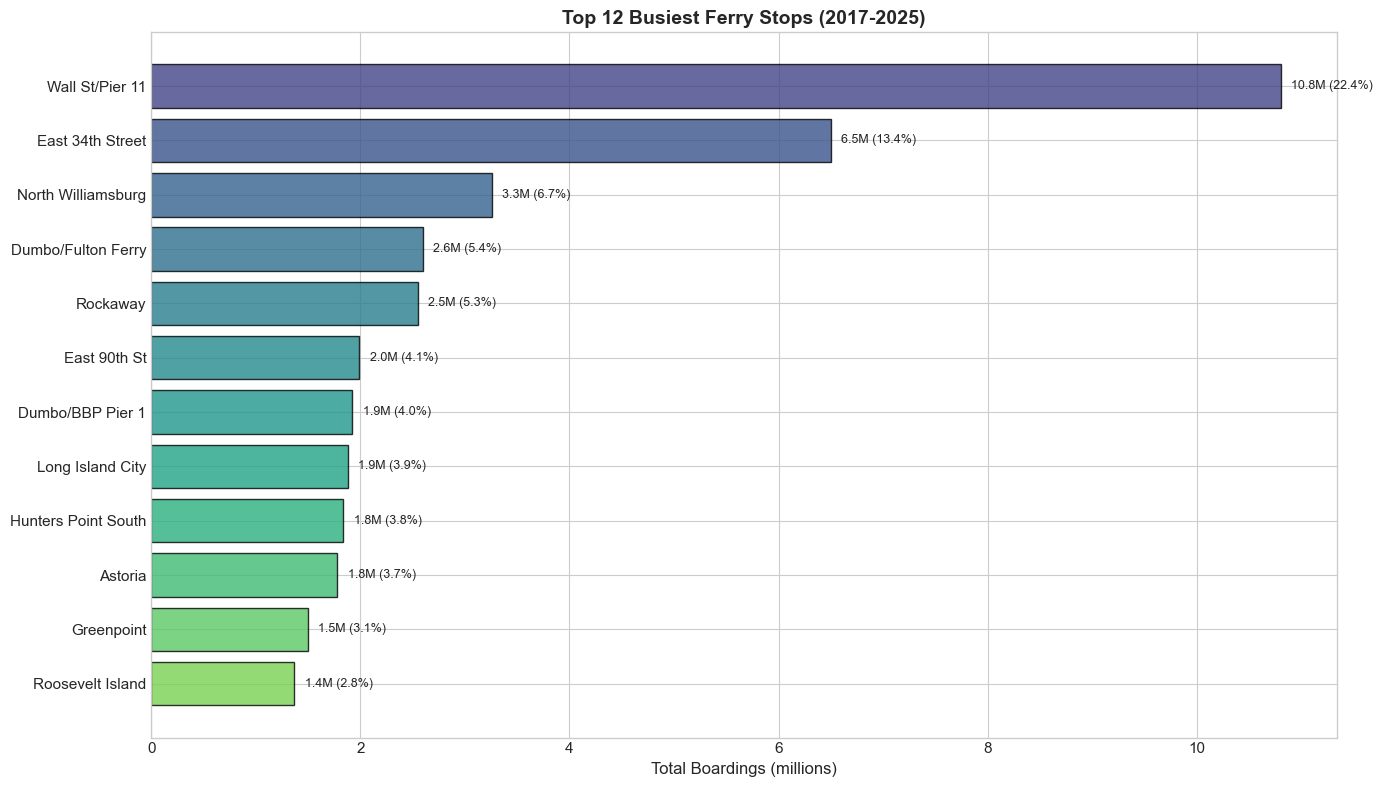


Top 2 stops (Wall St + E 34th St) account for 35.8% of all boardings!


In [31]:
# Visualize top stops
top_stops = stop_summary.head(12).reset_index()

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_stops)))
bars = ax.barh(range(len(top_stops)), top_stops['total_boardings']/1e6, color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_stops)))
ax.set_yticklabels(top_stops['stop'])
ax.invert_yaxis()
ax.set_xlabel('Total Boardings (millions)', fontsize=12)
ax.set_title('Top 12 Busiest Ferry Stops (2017-2025)', fontsize=14, fontweight='bold')

# Add value labels
for bar, val, pct in zip(bars, top_stops['total_boardings'], top_stops['pct_total']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{val/1e6:.1f}M ({pct:.1f}%)', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nTop 2 stops (Wall St + E 34th St) account for {stop_summary.head(2)['pct_total'].sum():.1f}% of all boardings!")

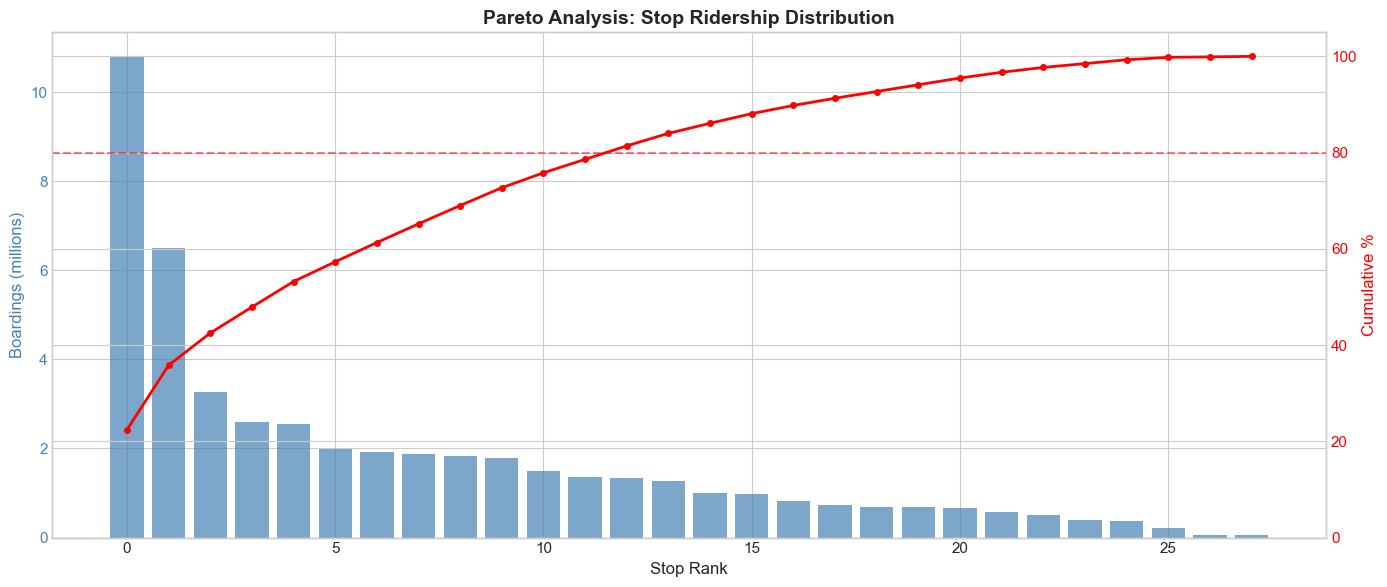


80/20 Analysis: 13 stops account for 80% of ridership (out of 28 total)


In [32]:
# Pareto chart - cumulative distribution
fig, ax1 = plt.subplots(figsize=(14, 6))

x = range(len(stop_summary))
ax1.bar(x, stop_summary['total_boardings']/1e6, color='steelblue', alpha=0.7, label='Individual')
ax1.set_ylabel('Boardings (millions)', color='steelblue', fontsize=12)
ax1.set_xlabel('Stop Rank', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(x, stop_summary['cumulative_pct'], color='red', marker='o', linewidth=2, markersize=4, label='Cumulative %')
ax2.axhline(y=80, color='red', linestyle='--', alpha=0.5)
ax2.set_ylabel('Cumulative %', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 105)

plt.title('Pareto Analysis: Stop Ridership Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find 80% threshold
stops_for_80 = (stop_summary['cumulative_pct'] <= 80).sum() + 1
print(f"\n80/20 Analysis: {stops_for_80} stops account for 80% of ridership (out of {len(stop_summary)} total)")

---

# Part 6: Interactive Maps

Visualizing ferry stops geographically with basemaps.

In [33]:
# Prepare stop data with coordinates from GTFS
# Create mapping from stop names to coordinates
stop_coords = stops[['stop_name', 'stop_lat', 'stop_lon']].drop_duplicates('stop_name')
stop_coords = stop_coords.rename(columns={'stop_name': 'stop'})

# Get ridership by stop
stop_ridership = ferry_clean.groupby('stop')['boardings'].sum().reset_index()
stop_ridership.columns = ['stop', 'total_boardings']

# Fuzzy match stop names (they may differ slightly)
def find_best_match(stop_name, gtfs_stops):
    """Find the best matching GTFS stop for a ridership stop name."""
    stop_lower = stop_name.lower()
    for gtfs_name in gtfs_stops:
        if gtfs_name.lower() in stop_lower or stop_lower in gtfs_name.lower():
            return gtfs_name
    # Try partial match
    for gtfs_name in gtfs_stops:
        # Match on key words
        if any(word in gtfs_name.lower() for word in stop_lower.split() if len(word) > 3):
            return gtfs_name
    return None

# Create matched dataset
gtfs_stop_names = stop_coords['stop'].unique()
stop_ridership['gtfs_match'] = stop_ridership['stop'].apply(lambda x: find_best_match(x, gtfs_stop_names))

# Merge with coordinates
stop_map_data = stop_ridership.merge(
    stop_coords, 
    left_on='gtfs_match', 
    right_on='stop', 
    how='left',
    suffixes=('', '_gtfs')
)

# Manual coordinate additions for unmatched high-volume stops
manual_coords = {
    'Wall St/Pier 11': (40.703161, -74.006144),
    'East 34th Street': (40.743912, -73.970731),
    'North Williamsburg': (40.720838, -73.964902),
    'Dumbo/Fulton Ferry': (40.703652, -73.995671),
    'Rockaway': (40.584228, -73.831596),
    'East 90th St': (40.777475, -73.942172),
    'Dumbo/BBP Pier 1': (40.700000, -73.997000),
    'Long Island City': (40.748420, -73.957725),
    'Hunters Point South': (40.741838, -73.961322),
    'Astoria': (40.771720, -73.935714),
    'Red Hook/Atlantic Basin': (40.680957, -74.013358),
    'South Williamsburg': (40.708743, -73.970224),
    'Bay Ridge': (40.639858, -74.038130),
    'Sunset Park/BAT': (40.646276, -74.026436),
    'Greenpoint': (40.731365, -73.963617),
    'Corlears Hook': (40.710159, -73.979244),
    'Stuyvesant Cove': (40.731979, -73.972922),
    'Soundview': (40.804202, -73.848703),
    'St. George': (40.646072, -74.074231),
    'Gov Island': (40.686640, -74.016482),
    'Atlantic Ave/BBP Pier 6': (40.692315, -74.002073),
    'Brooklyn Navy Yard': (40.701792, -73.973576),
    'Roosevelt Island': (40.756811, -73.952482),
    'Battery Park City': (40.715029, -74.017775),
    'Midtown West/Pier 79': (40.760323, -74.004075),
}

# Apply manual coordinates
for idx, row in stop_map_data.iterrows():
    if pd.isna(row['stop_lat']):
        for name, coords in manual_coords.items():
            if name.lower() in row['stop'].lower() or row['stop'].lower() in name.lower():
                stop_map_data.loc[idx, 'stop_lat'] = coords[0]
                stop_map_data.loc[idx, 'stop_lon'] = coords[1]
                break

# Filter to stops with coordinates
stop_map_data = stop_map_data.dropna(subset=['stop_lat', 'stop_lon'])
print(f"Stops with coordinates: {len(stop_map_data)} / {len(stop_ridership)}")
stop_map_data.head(10)

Stops with coordinates: 28 / 28


,stop,total_boardings,gtfs_match,stop_gtfs,stop_lat,stop_lon
0,Astoria,1780476,Astoria,Astoria,40.771720,-73.935714
1,Atlantic Ave/BBP Pier 6,723339,Atlantic Ave/BBP Pier 6,Atlantic Ave/BBP Pier 6,40.692315,-74.002073
2,Battery Park City/Vesey St.,572942,Battery Park City/Vesey St.,Battery Park City/Vesey St.,40.715029,-74.017775
3,Bay Ridge,818980,Bay Ridge,Bay Ridge,40.639858,-74.038130
4,Brooklyn Navy Yard,652604,Brooklyn Navy Yard,Brooklyn Navy Yard,40.701792,-73.973576
5,Corlears Hook,223430,Corlears Hook,Corlears Hook,40.710159,-73.979244
6,Dumbo,64832,Dumbo/Fulton Ferry,Dumbo/Fulton Ferry,40.703652,-73.995671
7,Dumbo/BBP Pier 1,1923275,Atlantic Ave/BBP Pier 6,Atlantic Ave/BBP Pier 6,40.692315,-74.002073
8,Dumbo/Fulton Ferry,2597466,Dumbo/Fulton Ferry,Dumbo/Fulton Ferry,40.703652,-73.995671
9,East 34th Street,6497418,East 34th Street,East 34th Street,40.743912,-73.970731


In [34]:
# Create interactive map with all ferry stops
# Center on NYC
center_lat = 40.72
center_lon = -73.97

# Create map with CartoDB basemap
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='CartoDB positron'
)

# Add ferry stops as circle markers, sized by ridership
max_ridership = stop_map_data['total_boardings'].max()

for _, row in stop_map_data.iterrows():
    # Scale radius based on ridership (5-30 pixel range)
    radius = 5 + (row['total_boardings'] / max_ridership) * 25
    
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=radius,
        color='darkblue',
        fill=True,
        fillColor='#00839C',
        fillOpacity=0.7,
        weight=2,
        popup=folium.Popup(
            f"<b>{row['stop']}</b><br>"
            f"Total Boardings: {row['total_boardings']:,.0f}<br>"
            f"Share: {row['total_boardings']/stop_map_data['total_boardings'].sum()*100:.1f}%",
            max_width=250
        ),
        tooltip=row['stop']
    ).add_to(m)

# Add title
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 350px; 
            background-color: white; z-index:9999; 
            padding: 10px; border-radius: 5px;
            box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
    <h4 style="margin: 0;">NYC Ferry Stops by Ridership</h4>
    <p style="margin: 5px 0 0 0; font-size: 12px;">Circle size = total boardings (2017-2025)</p>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

m

In [35]:
# Create a heatmap of ridership
m_heat = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='CartoDB dark_matter'
)

# Prepare heatmap data (lat, lon, weight)
heat_data = stop_map_data[['stop_lat', 'stop_lon', 'total_boardings']].values.tolist()

# Add heatmap layer
HeatMap(
    heat_data,
    min_opacity=0.4,
    max_zoom=15,
    radius=25,
    blur=15,
    gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'yellow', 0.8: 'orange', 1: 'red'}
).add_to(m_heat)

# Add title
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 350px; 
            background-color: rgba(0,0,0,0.7); color: white; z-index:9999; 
            padding: 10px; border-radius: 5px;">
    <h4 style="margin: 0;">Ferry Ridership Heatmap</h4>
    <p style="margin: 5px 0 0 0; font-size: 12px;">Red = highest ridership concentration</p>
</div>
'''
m_heat.get_root().html.add_child(folium.Element(title_html))

m_heat

In [36]:
# Create map showing all GTFS stops (even those without ridership data)
m_all = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Add all GTFS stops
for _, row in stops.iterrows():
    folium.Marker(
        location=[row['stop_lat'], row['stop_lon']],
        popup=f"<b>{row['stop_name']}</b><br>ID: {row['stop_id']}",
        tooltip=row['stop_name'],
        icon=folium.Icon(color='blue', icon='ship', prefix='fa')
    ).add_to(m_all)

# Add title
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 300px; 
            background-color: white; z-index:9999; 
            padding: 10px; border-radius: 5px;
            box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
    <h4 style="margin: 0;">All NYC Ferry GTFS Stops</h4>
    <p style="margin: 5px 0 0 0; font-size: 12px;">52 stops from GTFS feed</p>
</div>
'''
m_all.get_root().html.add_child(folium.Element(title_html))

m_all

In [37]:
# Map with route colors
m_routes = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='CartoDB positron'
)

# Get primary route for each stop
stop_routes = ferry_clean.groupby(['stop', 'route'])['boardings'].sum().reset_index()
stop_primary_route = stop_routes.loc[stop_routes.groupby('stop')['boardings'].idxmax()]

# Merge with coordinates
stop_routes_map = stop_map_data.merge(stop_primary_route[['stop', 'route']], on='stop', how='left')

# Add markers colored by route
for _, row in stop_routes_map.iterrows():
    route = row['route'] if pd.notna(row['route']) else 'Unknown'
    color = route_colors.get(route, '#808080')
    
    radius = 5 + (row['total_boardings'] / max_ridership) * 25
    
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=radius,
        color='black',
        fill=True,
        fillColor=color,
        fillOpacity=0.8,
        weight=1,
        popup=folium.Popup(
            f"<b>{row['stop']}</b><br>"
            f"Primary Route: {route_names.get(route, route)}<br>"
            f"Boardings: {row['total_boardings']:,.0f}",
            max_width=250
        ),
        tooltip=f"{row['stop']} ({route})"
    ).add_to(m_routes)

# Add legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 150px; 
            background-color: white; z-index:9999; 
            padding: 10px; border-radius: 5px;
            box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
    <h5 style="margin: 0 0 10px 0;">Routes</h5>
    <div><span style="background:#00839C;padding:2px 8px;margin-right:5px;">&nbsp;</span>East River</div>
    <div><span style="background:#FF6B00;padding:2px 8px;margin-right:5px;">&nbsp;</span>Astoria</div>
    <div><span style="background:#FFD100;padding:2px 8px;margin-right:5px;">&nbsp;</span>South Brooklyn</div>
    <div><span style="background:#B218AA;padding:2px 8px;margin-right:5px;">&nbsp;</span>Rockaway</div>
    <div><span style="background:#4E008E;padding:2px 8px;margin-right:5px;">&nbsp;</span>Soundview</div>
    <div><span style="background:#D0006F;padding:2px 8px;margin-right:5px;">&nbsp;</span>St. George</div>
</div>
'''
m_routes.get_root().html.add_child(folium.Element(legend_html))

# Add title
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 350px; 
            background-color: white; z-index:9999; 
            padding: 10px; border-radius: 5px;
            box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
    <h4 style="margin: 0;">Ferry Stops by Primary Route</h4>
    <p style="margin: 5px 0 0 0; font-size: 12px;">Size = ridership, Color = dominant route</p>
</div>
'''
m_routes.get_root().html.add_child(folium.Element(title_html))

m_routes

---

# Part 7: Weekday vs Weekend Analysis

Understanding commuter (weekday) vs recreational (weekend) usage patterns.

In [38]:
# Overall weekday vs weekend comparison
daytype_summary = ferry_clean.groupby('typeday').agg({
    'boardings': ['sum', 'mean', 'count']
}).round(1)
daytype_summary.columns = ['total_boardings', 'avg_boardings', 'observations']

print("Weekday vs Weekend Summary:")
daytype_summary['boardings_per_obs'] = (daytype_summary['total_boardings'] / daytype_summary['observations']).round(1)
daytype_summary

Weekday vs Weekend Summary:


,total_boardings,avg_boardings,observations,boardings_per_obs
typeday,,,,
Weekday,32193381,22.4,1437227,22.4
Weekend,16127754,32.2,500749,32.2


In [39]:
# Weekday vs weekend by route
route_daytype = ferry_clean.groupby(['route', 'typeday'])['boardings'].agg(['sum', 'mean']).unstack()
route_daytype.columns = ['total_weekday', 'total_weekend', 'avg_weekday', 'avg_weekend']
route_daytype['weekend_vs_weekday_ratio'] = (route_daytype['avg_weekend'] / route_daytype['avg_weekday']).round(2)
route_daytype = route_daytype.sort_values('weekend_vs_weekday_ratio', ascending=False)

print("\nWeekend vs Weekday Ratio by Route:")
print("(Values > 1 indicate higher weekend ridership per trip)")
route_daytype[['avg_weekday', 'avg_weekend', 'weekend_vs_weekday_ratio']]


Weekend vs Weekday Ratio by Route:
(Values > 1 indicate higher weekend ridership per trip)


,avg_weekday,avg_weekend,weekend_vs_weekday_ratio
route,,,
SB,12.603671,22.393133,1.78
RW,29.574697,52.346102,1.77
ER,32.927928,45.057614,1.37
AS,19.961629,26.936062,1.35
LE,9.776963,11.607908,1.19
SV,17.601812,20.731700,1.18
SG,24.875734,29.168545,1.17
GI,109.508621,83.181224,0.76
RR,NaN,110.118734,NaN


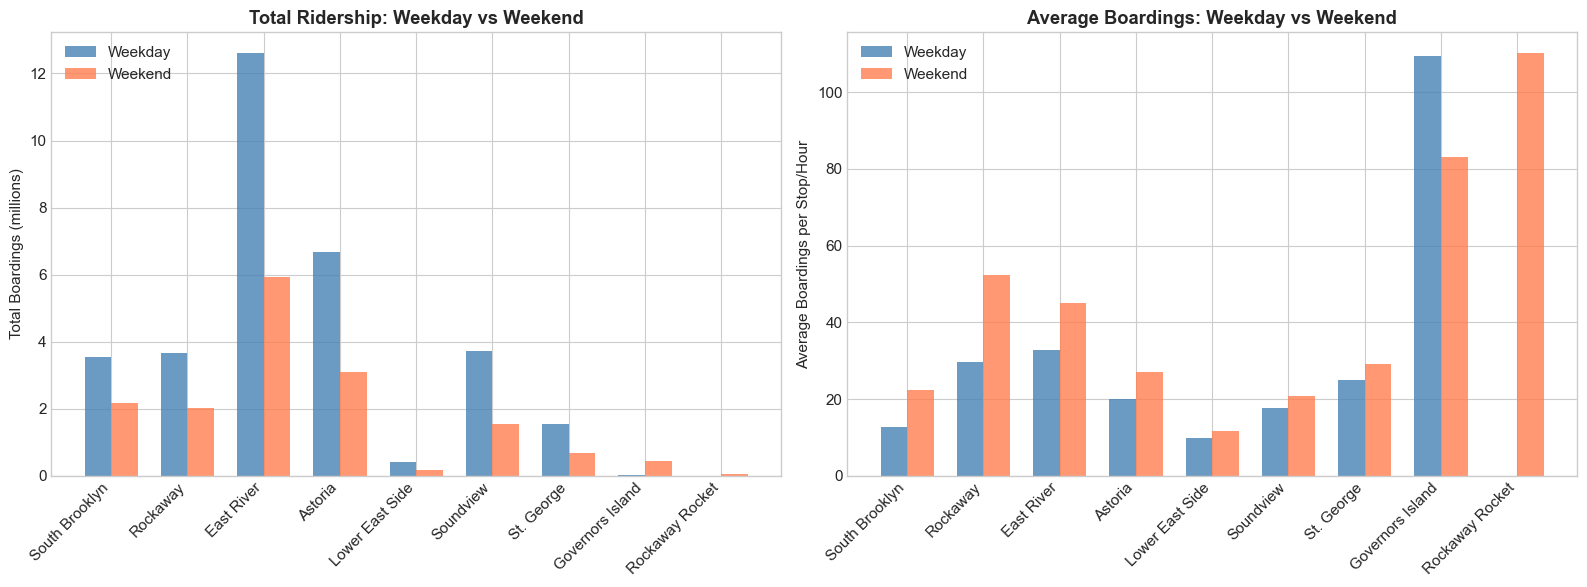


Key Insight: Rockaway and Governors Island show strongest weekend bias (recreational/tourist).
East River and Soundview are more weekday-oriented (commuter).


In [40]:
# Visualize weekday vs weekend patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total ridership comparison
x = np.arange(len(route_daytype))
width = 0.35

route_names_list = [route_names.get(r, r) for r in route_daytype.index]

axes[0].bar(x - width/2, route_daytype['total_weekday']/1e6, width, label='Weekday', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, route_daytype['total_weekend']/1e6, width, label='Weekend', color='coral', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(route_names_list, rotation=45, ha='right')
axes[0].set_ylabel('Total Boardings (millions)')
axes[0].set_title('Total Ridership: Weekday vs Weekend', fontweight='bold')
axes[0].legend()

# Average per observation
axes[1].bar(x - width/2, route_daytype['avg_weekday'], width, label='Weekday', color='steelblue', alpha=0.8)
axes[1].bar(x + width/2, route_daytype['avg_weekend'], width, label='Weekend', color='coral', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(route_names_list, rotation=45, ha='right')
axes[1].set_ylabel('Average Boardings per Stop/Hour')
axes[1].set_title('Average Boardings: Weekday vs Weekend', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nKey Insight: Rockaway and Governors Island show strongest weekend bias (recreational/tourist).")
print("East River and Soundview are more weekday-oriented (commuter).")

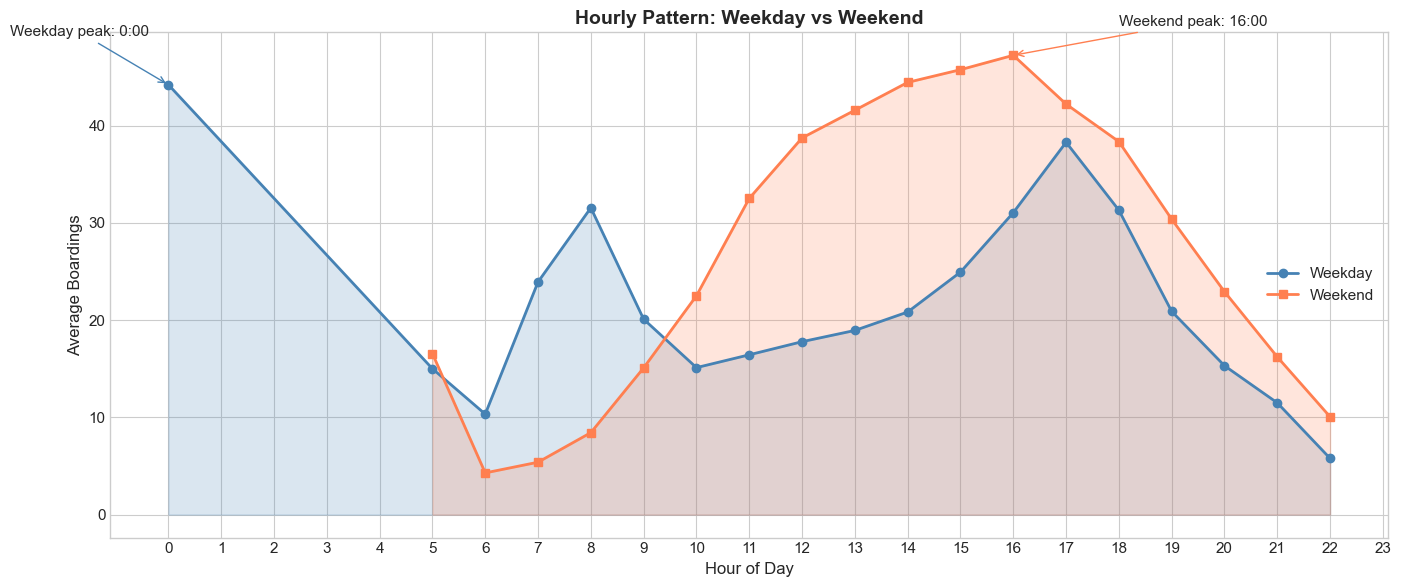


Weekday shows classic commuter double-peak (AM/PM rush).
Weekend shows a broader midday plateau - leisure/tourist usage.


In [41]:
# Hourly pattern comparison: weekday vs weekend
hourly_daytype = ferry_clean.groupby(['hour', 'typeday'])['boardings'].mean().unstack()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(hourly_daytype.index, hourly_daytype['Weekday'], marker='o', linewidth=2, 
        markersize=6, label='Weekday', color='steelblue')
ax.plot(hourly_daytype.index, hourly_daytype['Weekend'], marker='s', linewidth=2, 
        markersize=6, label='Weekend', color='coral')

ax.fill_between(hourly_daytype.index, hourly_daytype['Weekday'], alpha=0.2, color='steelblue')
ax.fill_between(hourly_daytype.index, hourly_daytype['Weekend'], alpha=0.2, color='coral')

ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Average Boardings', fontsize=12)
ax.set_title('Hourly Pattern: Weekday vs Weekend', fontsize=14, fontweight='bold')
ax.set_xticks(range(24))
ax.legend(fontsize=11)

# Annotate peaks
weekday_peak = hourly_daytype['Weekday'].idxmax()
weekend_peak = hourly_daytype['Weekend'].idxmax()
ax.annotate(f'Weekday peak: {weekday_peak}:00', 
            xy=(weekday_peak, hourly_daytype['Weekday'].max()),
            xytext=(weekday_peak-3, hourly_daytype['Weekday'].max()+5),
            arrowprops=dict(arrowstyle='->', color='steelblue'))
ax.annotate(f'Weekend peak: {weekend_peak}:00', 
            xy=(weekend_peak, hourly_daytype['Weekend'].max()),
            xytext=(weekend_peak+2, hourly_daytype['Weekend'].max()+3),
            arrowprops=dict(arrowstyle='->', color='coral'))

plt.tight_layout()
plt.show()

print("\nWeekday shows classic commuter double-peak (AM/PM rush).")
print("Weekend shows a broader midday plateau - leisure/tourist usage.")

---

# Part 8: Seasonal Analysis

How does ridership vary across seasons? What's the summer vs winter swing?

In [42]:
# Seasonal summary
seasonal = ferry_clean.groupby('season').agg({
    'boardings': ['sum', 'mean', 'count']
}).round(1)
seasonal.columns = ['total_boardings', 'avg_boardings', 'observations']

# Reorder seasons
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal = seasonal.reindex(season_order)

print("Seasonal Ridership Summary:")
seasonal['pct_of_year'] = (seasonal['total_boardings'] / seasonal['total_boardings'].sum() * 100).round(1)
seasonal

Seasonal Ridership Summary:


,total_boardings,avg_boardings,observations,pct_of_year
season,,,,
Winter,6140402,14.6,419541,12.7
Spring,10342430,22.6,456925,21.4
Summer,18463794,34.4,536025,38.2
Fall,13374509,25.5,525485,27.7


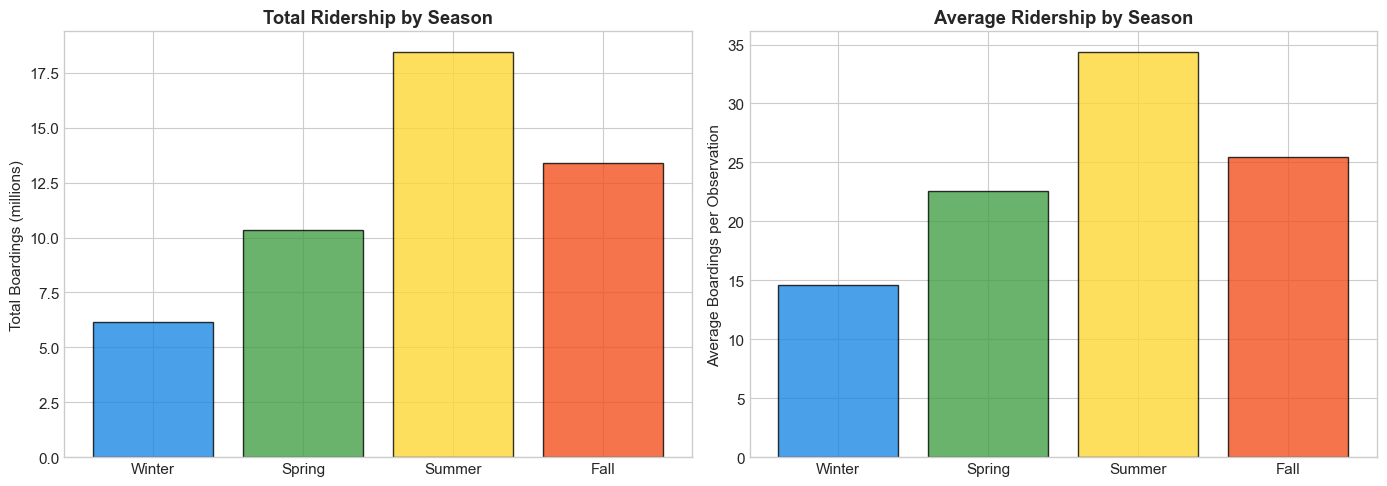


Summer is 3.0x Winter ridership!


In [43]:
# Visualize seasonal patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

season_colors = {'Winter': '#1E88E5', 'Spring': '#43A047', 'Summer': '#FDD835', 'Fall': '#F4511E'}
colors = [season_colors[s] for s in seasonal.index]

# Total boardings
axes[0].bar(seasonal.index, seasonal['total_boardings']/1e6, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_ylabel('Total Boardings (millions)')
axes[0].set_title('Total Ridership by Season', fontweight='bold')

# Average boardings
axes[1].bar(seasonal.index, seasonal['avg_boardings'], color=colors, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('Average Boardings per Observation')
axes[1].set_title('Average Ridership by Season', fontweight='bold')

plt.tight_layout()
plt.show()

summer_winter_ratio = seasonal.loc['Summer', 'total_boardings'] / seasonal.loc['Winter', 'total_boardings']
print(f"\nSummer is {summer_winter_ratio:.1f}x Winter ridership!")

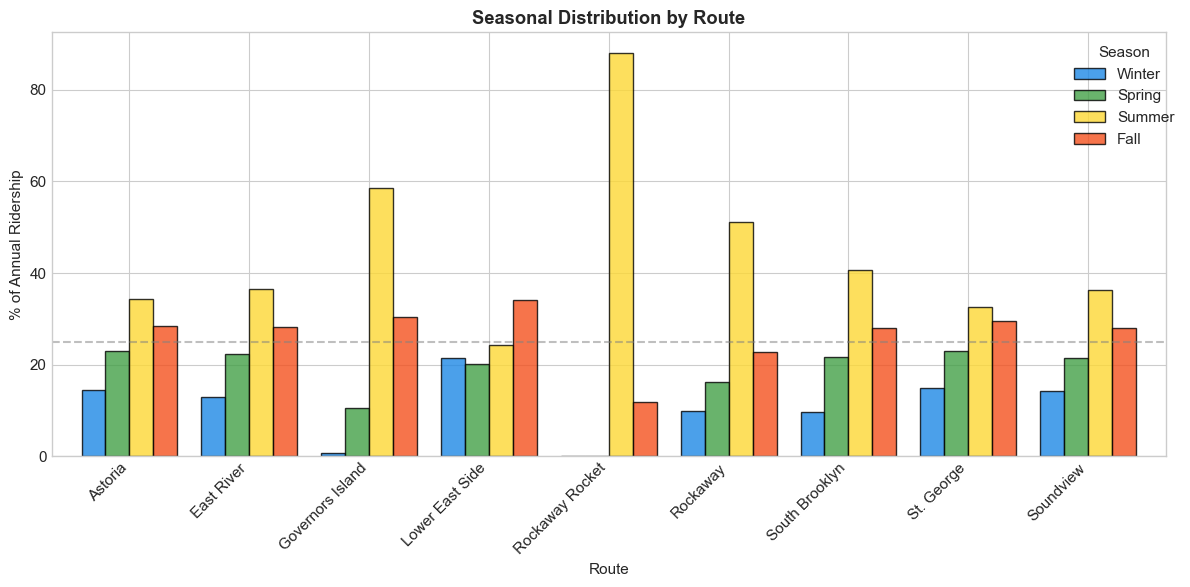


Rockaway and Governors Island show extreme summer seasonality (beach destinations).
East River and Soundview are more consistent year-round (commuter routes).


In [44]:
# Seasonal pattern by route
route_season = ferry_clean.groupby(['route', 'season'])['boardings'].sum().unstack()
route_season = route_season[season_order]  # Reorder columns

# Normalize to percentages for each route
route_season_pct = route_season.div(route_season.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 6))
route_season_pct.plot(kind='bar', ax=ax, color=[season_colors[s] for s in season_order], 
                      edgecolor='black', alpha=0.8, width=0.8)
ax.set_xlabel('Route')
ax.set_ylabel('% of Annual Ridership')
ax.set_title('Seasonal Distribution by Route', fontweight='bold')
ax.legend(title='Season', bbox_to_anchor=(1.02, 1))
ax.set_xticklabels([route_names.get(r, r) for r in route_season_pct.index], rotation=45, ha='right')
ax.axhline(y=25, color='gray', linestyle='--', alpha=0.5, label='Equal distribution')

plt.tight_layout()
plt.show()

print("\nRockaway and Governors Island show extreme summer seasonality (beach destinations).")
print("East River and Soundview are more consistent year-round (commuter routes).")

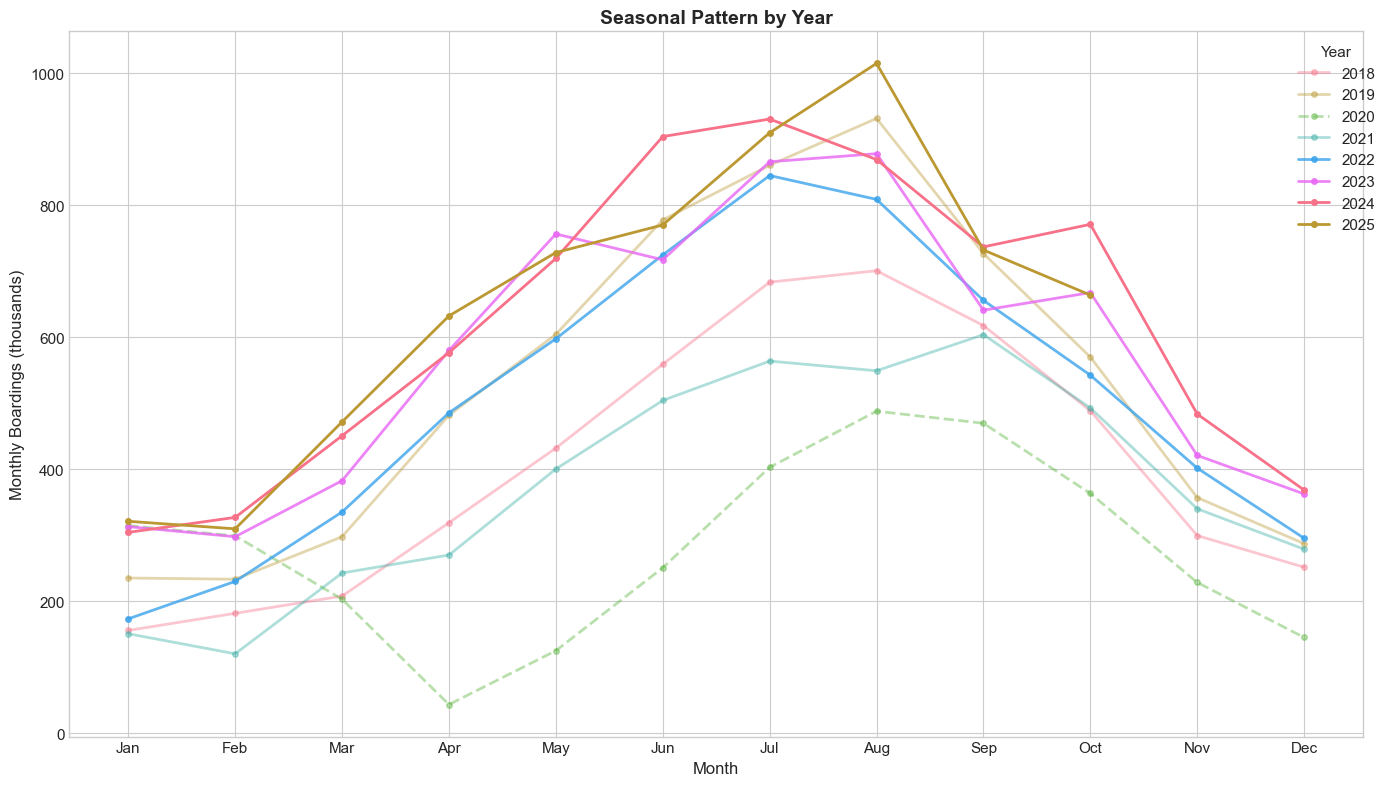


2020 shows dramatic COVID impact.
2024-2025 show record ridership, especially in summer months.


In [45]:
# Monthly seasonality by year
monthly_year = ferry_clean.groupby(['year', 'month'])['boardings'].sum().unstack()

fig, ax = plt.subplots(figsize=(14, 8))
for year in monthly_year.index:
    if year >= 2018:  # Skip partial 2017
        style = '-' if year < 2020 else '--' if year == 2020 else '-'
        alpha = 0.4 if year < 2022 else 0.8 if year < 2024 else 1.0
        ax.plot(monthly_year.columns, monthly_year.loc[year]/1e3, 
                marker='o', linewidth=2, markersize=4,
                label=str(year), alpha=alpha, linestyle=style)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Boardings (thousands)', fontsize=12)
ax.set_title('Seasonal Pattern by Year', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(title='Year', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

print("\n2020 shows dramatic COVID impact.")
print("2024-2025 show record ridership, especially in summer months.")

---

# Part 9: Growth Trends & COVID Impact

Analyzing long-term growth and pandemic recovery.

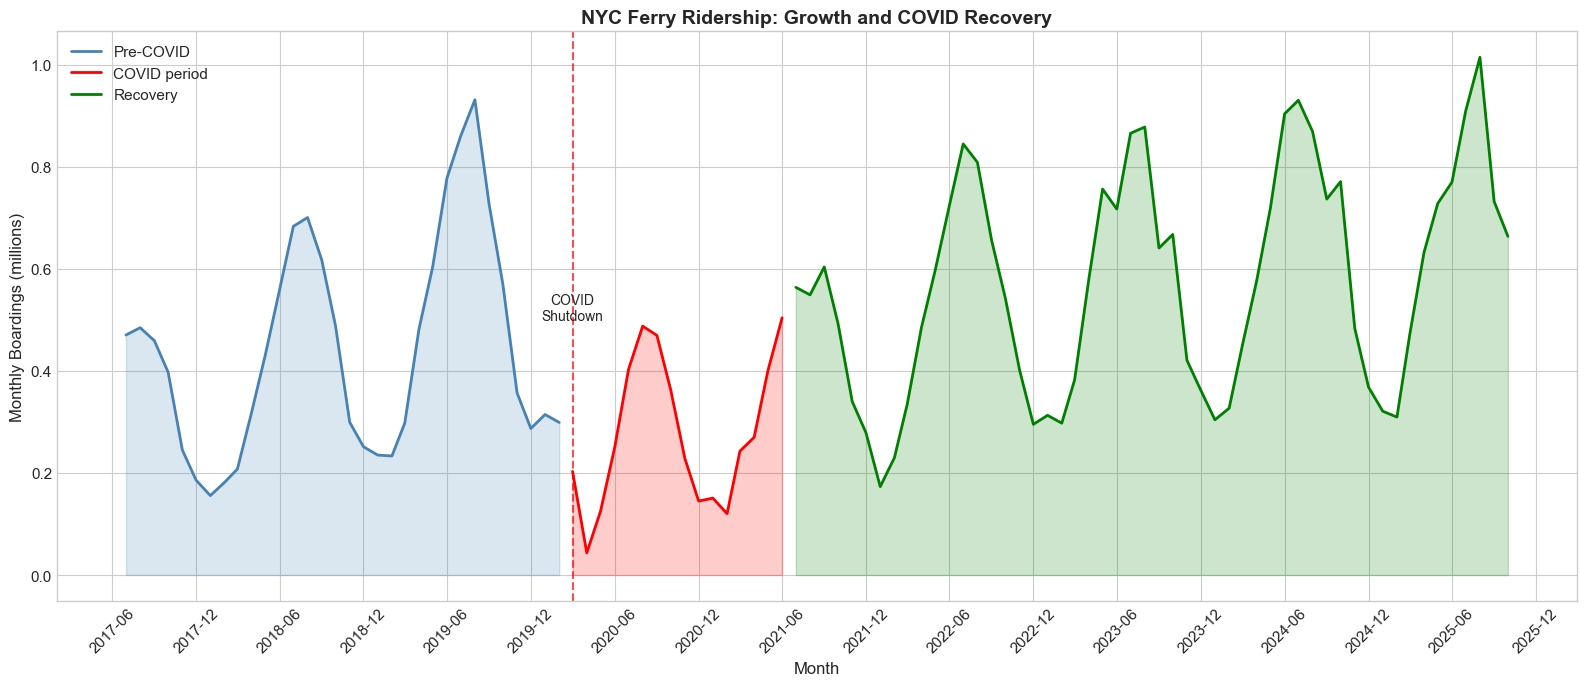

In [46]:
# Monthly ridership with trend line
monthly_trend = ferry_clean.groupby(ferry_clean['date'].dt.to_period('M'))['boardings'].sum().reset_index()
monthly_trend.columns = ['month', 'boardings']
monthly_trend['month_num'] = range(len(monthly_trend))
monthly_trend['month'] = monthly_trend['month'].dt.to_timestamp()

# Separate pre-COVID, COVID, and post-COVID periods
pre_covid = monthly_trend[monthly_trend['month'] < '2020-03-01']
covid = monthly_trend[(monthly_trend['month'] >= '2020-03-01') & (monthly_trend['month'] < '2021-07-01')]
post_covid = monthly_trend[monthly_trend['month'] >= '2021-07-01']

fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(pre_covid['month'], pre_covid['boardings']/1e6, linewidth=2, color='steelblue', label='Pre-COVID')
ax.plot(covid['month'], covid['boardings']/1e6, linewidth=2, color='red', label='COVID period')
ax.plot(post_covid['month'], post_covid['boardings']/1e6, linewidth=2, color='green', label='Recovery')

ax.fill_between(pre_covid['month'], pre_covid['boardings']/1e6, alpha=0.2, color='steelblue')
ax.fill_between(covid['month'], covid['boardings']/1e6, alpha=0.2, color='red')
ax.fill_between(post_covid['month'], post_covid['boardings']/1e6, alpha=0.2, color='green')

# Add annotations
ax.axvline(x=pd.Timestamp('2020-03-01'), color='red', linestyle='--', alpha=0.7)
ax.annotate('COVID\nShutdown', xy=(pd.Timestamp('2020-03-01'), 0.5), fontsize=10, ha='center')

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Boardings (millions)', fontsize=12)
ax.set_title('NYC Ferry Ridership: Growth and COVID Recovery', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

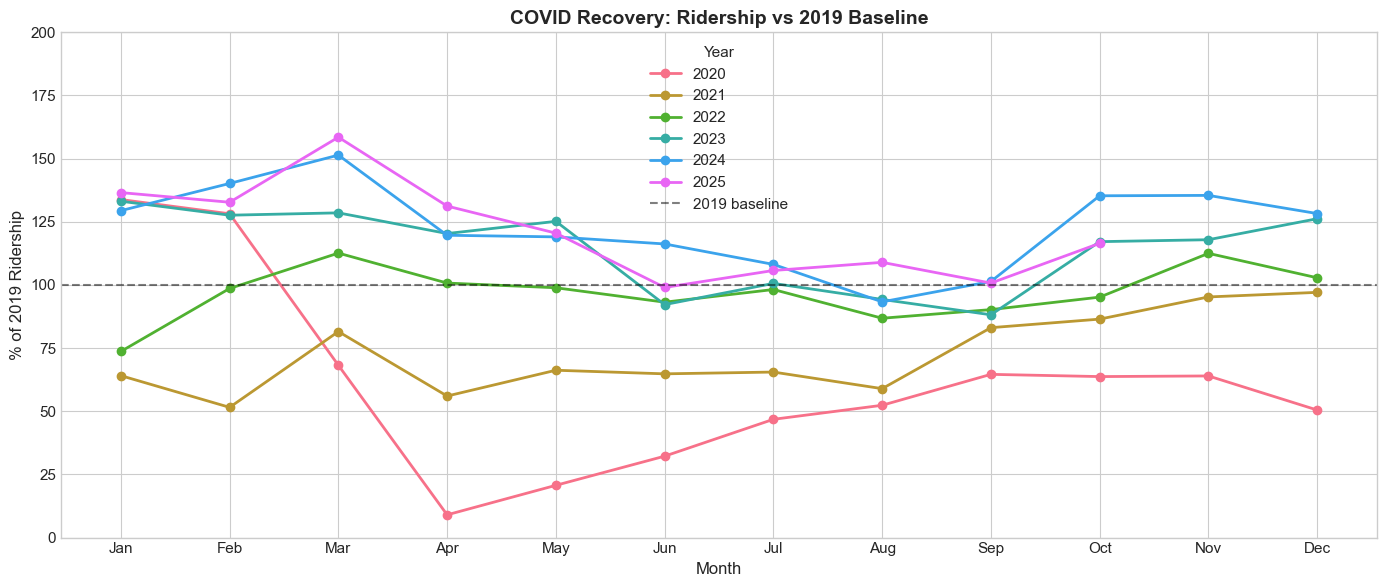


Key Findings:
- 2020 dropped to 20-40% of 2019 levels
- 2022-2023 exceeded 2019 baseline
- 2024-2025 show 150%+ of 2019 in summer months!


In [47]:
# COVID recovery analysis
# Compare 2019 (pre-COVID baseline) to subsequent years
yearly_monthly = ferry_clean.groupby(['year', 'month'])['boardings'].sum().unstack()

# Calculate recovery percentage vs 2019
baseline_2019 = yearly_monthly.loc[2019]
recovery_pct = yearly_monthly.div(baseline_2019) * 100

fig, ax = plt.subplots(figsize=(14, 6))
for year in [2020, 2021, 2022, 2023, 2024, 2025]:
    if year in recovery_pct.index:
        color = 'red' if year == 2020 else 'orange' if year == 2021 else 'green'
        ax.plot(recovery_pct.columns, recovery_pct.loc[year], 
                marker='o', linewidth=2, label=str(year))

ax.axhline(y=100, color='black', linestyle='--', alpha=0.5, label='2019 baseline')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('% of 2019 Ridership', fontsize=12)
ax.set_title('COVID Recovery: Ridership vs 2019 Baseline', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(title='Year')
ax.set_ylim(0, 200)

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print("- 2020 dropped to 20-40% of 2019 levels")
print("- 2022-2023 exceeded 2019 baseline")
print("- 2024-2025 show 150%+ of 2019 in summer months!")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


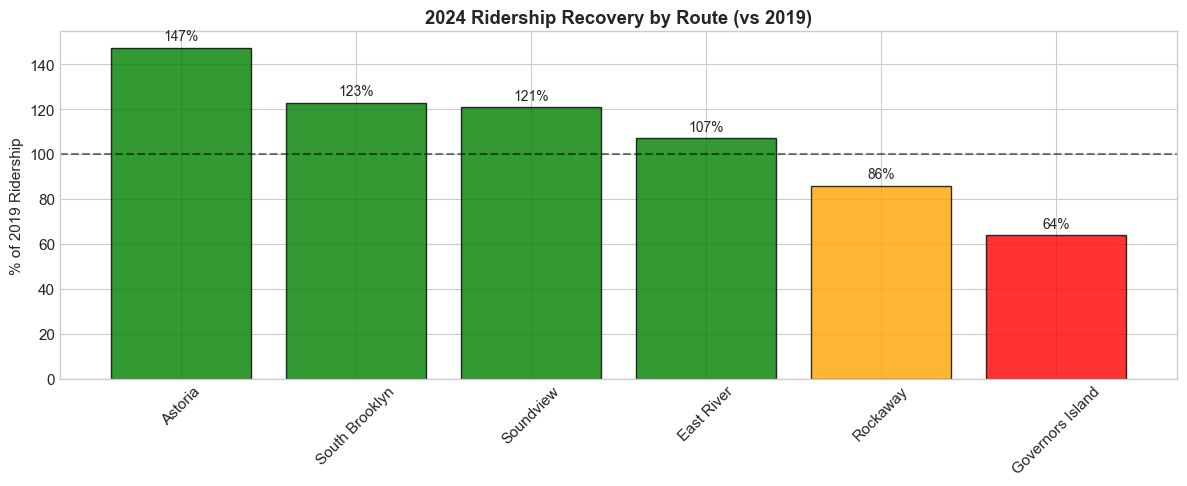

In [48]:
# Route-level recovery
route_yearly = ferry_clean.groupby(['year', 'route'])['boardings'].sum().unstack()

# Calculate 2024 vs 2019 for each route
if 2019 in route_yearly.index and 2024 in route_yearly.index:
    recovery_by_route = (route_yearly.loc[2024] / route_yearly.loc[2019] * 100).round(1)
    recovery_by_route = recovery_by_route.sort_values(ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    colors = ['green' if v > 100 else 'orange' if v > 80 else 'red' for v in recovery_by_route]
    bars = ax.bar([route_names.get(r, r) for r in recovery_by_route.index], 
                  recovery_by_route.values, color=colors, edgecolor='black', alpha=0.8)
    ax.axhline(y=100, color='black', linestyle='--', alpha=0.5, label='2019 = 100%')
    ax.set_ylabel('% of 2019 Ridership')
    ax.set_title('2024 Ridership Recovery by Route (vs 2019)', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, val in zip(bars, recovery_by_route.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{val:.0f}%', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [49]:
# Calculate compound annual growth rate (CAGR)
yearly_totals = ferry_clean.groupby('year')['boardings'].sum()

# CAGR from 2018 to 2024 (full years, excluding partial 2017 and 2025)
if 2018 in yearly_totals.index and 2024 in yearly_totals.index:
    start_val = yearly_totals[2018]
    end_val = yearly_totals[2024]
    years = 6
    cagr = ((end_val / start_val) ** (1/years) - 1) * 100
    
    print(f"Compound Annual Growth Rate (2018-2024): {cagr:.1f}%")
    print(f"\n2018 ridership: {start_val:,.0f}")
    print(f"2024 ridership: {end_val:,.0f}")
    print(f"Total growth: {(end_val/start_val - 1)*100:.1f}%")

Compound Annual Growth Rate (2018-2024): 7.2%

2018 ridership: 4,895,896
2024 ridership: 7,440,950
Total growth: 52.0%


---

# Part 10: Private Ferry Comparison

How does NYC Ferry compare to private operators like NY Waterway?

In [50]:
# Clean private ferry data
from datetime import date
private_clean = private_ferry[pd.to_datetime(private_ferry['date']) >= pd.Timestamp('2013-01-01')].copy()
private_clean['date'] = pd.to_datetime(private_clean['date'])
private_clean['year'] = private_clean['date'].dt.year
private_clean['month'] = private_clean['date'].dt.month

print("Private Ferry Dataset Summary:")
print(f"Date range: {private_clean['date'].min()} to {private_clean['date'].max()}")
print(f"Total records: {len(private_clean):,}")
print(f"Total ridership: {private_clean['ridership'].sum():,.0f}")

Private Ferry Dataset Summary:
Date range: 2013-01-01 00:00:00 to 2025-10-31 00:00:00
Total records: 252,155
Total ridership: 137,625,733


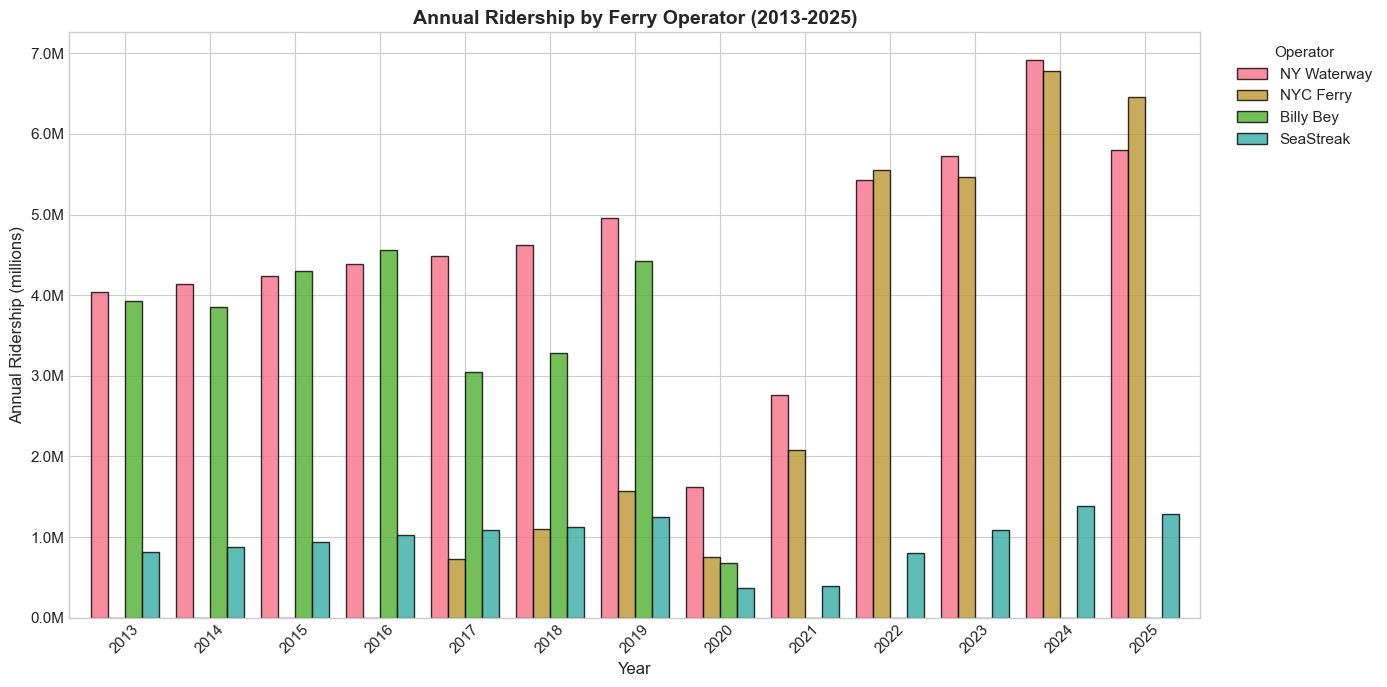

In [51]:
# Annual ridership by operator
operator_yearly = private_clean.groupby(['year', 'operator'])['ridership'].sum().unstack(fill_value=0)

# Select major operators
major_operators = ['NY Waterway', 'NYC Ferry', 'Billy Bey', 'SeaStreak']
operator_yearly_major = operator_yearly[[op for op in major_operators if op in operator_yearly.columns]]

fig, ax = plt.subplots(figsize=(14, 7))
operator_yearly_major.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', alpha=0.8)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annual Ridership (millions)', fontsize=12)
ax.set_title('Annual Ridership by Ferry Operator (2013-2025)', fontsize=14, fontweight='bold')
ax.legend(title='Operator', bbox_to_anchor=(1.02, 1))

# Format y-axis in millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

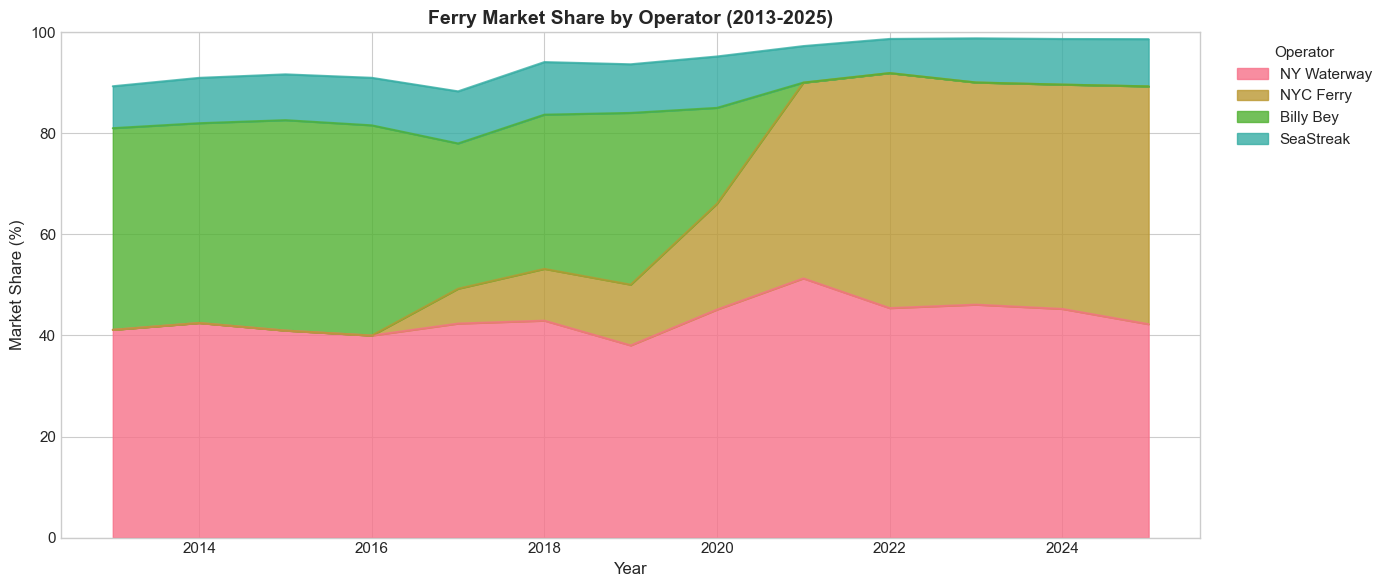


Key Observations:
- NYC Ferry launched in 2017 and rapidly gained market share
- Billy Bey ceased operations in 2020 (COVID casualty)
- By 2024, NYC Ferry rivals NY Waterway as largest operator


In [52]:
# Market share over time
operator_yearly['total'] = operator_yearly.sum(axis=1)
market_share = operator_yearly[major_operators].div(operator_yearly['total'], axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 6))
market_share.plot(kind='area', ax=ax, stacked=True, alpha=0.8)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Market Share (%)', fontsize=12)
ax.set_title('Ferry Market Share by Operator (2013-2025)', fontsize=14, fontweight='bold')
ax.legend(title='Operator', bbox_to_anchor=(1.02, 1))
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- NYC Ferry launched in 2017 and rapidly gained market share")
print("- Billy Bey ceased operations in 2020 (COVID casualty)")
print("- By 2024, NYC Ferry rivals NY Waterway as largest operator")

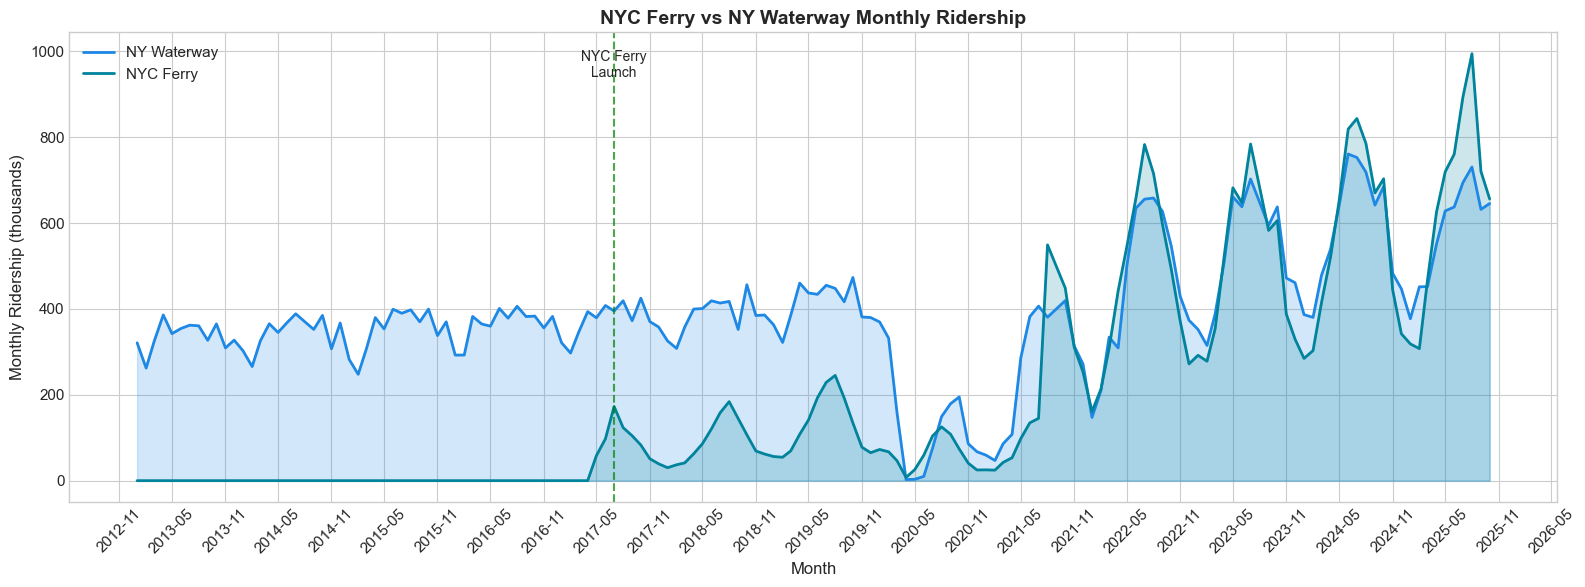

In [53]:
# Monthly comparison of NYC Ferry vs NY Waterway
operator_monthly = private_clean[private_clean['operator'].isin(['NYC Ferry', 'NY Waterway'])].copy()
operator_monthly = operator_monthly.groupby([operator_monthly['date'].dt.to_period('M'), 'operator'])['ridership'].sum().unstack(fill_value=0)
operator_monthly.index = operator_monthly.index.to_timestamp()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(operator_monthly.index, operator_monthly['NY Waterway']/1e3, 
        label='NY Waterway', linewidth=2, color='#1E88E5')
ax.plot(operator_monthly.index, operator_monthly['NYC Ferry']/1e3, 
        label='NYC Ferry', linewidth=2, color='#00839C')

ax.fill_between(operator_monthly.index, operator_monthly['NY Waterway']/1e3, alpha=0.2, color='#1E88E5')
ax.fill_between(operator_monthly.index, operator_monthly['NYC Ferry']/1e3, alpha=0.2, color='#00839C')

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Monthly Ridership (thousands)', fontsize=12)
ax.set_title('NYC Ferry vs NY Waterway Monthly Ridership', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

# Mark NYC Ferry launch
ax.axvline(x=pd.Timestamp('2017-07-01'), color='green', linestyle='--', alpha=0.7)
ax.annotate('NYC Ferry\nLaunch', xy=(pd.Timestamp('2017-07-01'), ax.get_ylim()[1]*0.9), 
            fontsize=10, ha='center')

plt.tight_layout()
plt.show()

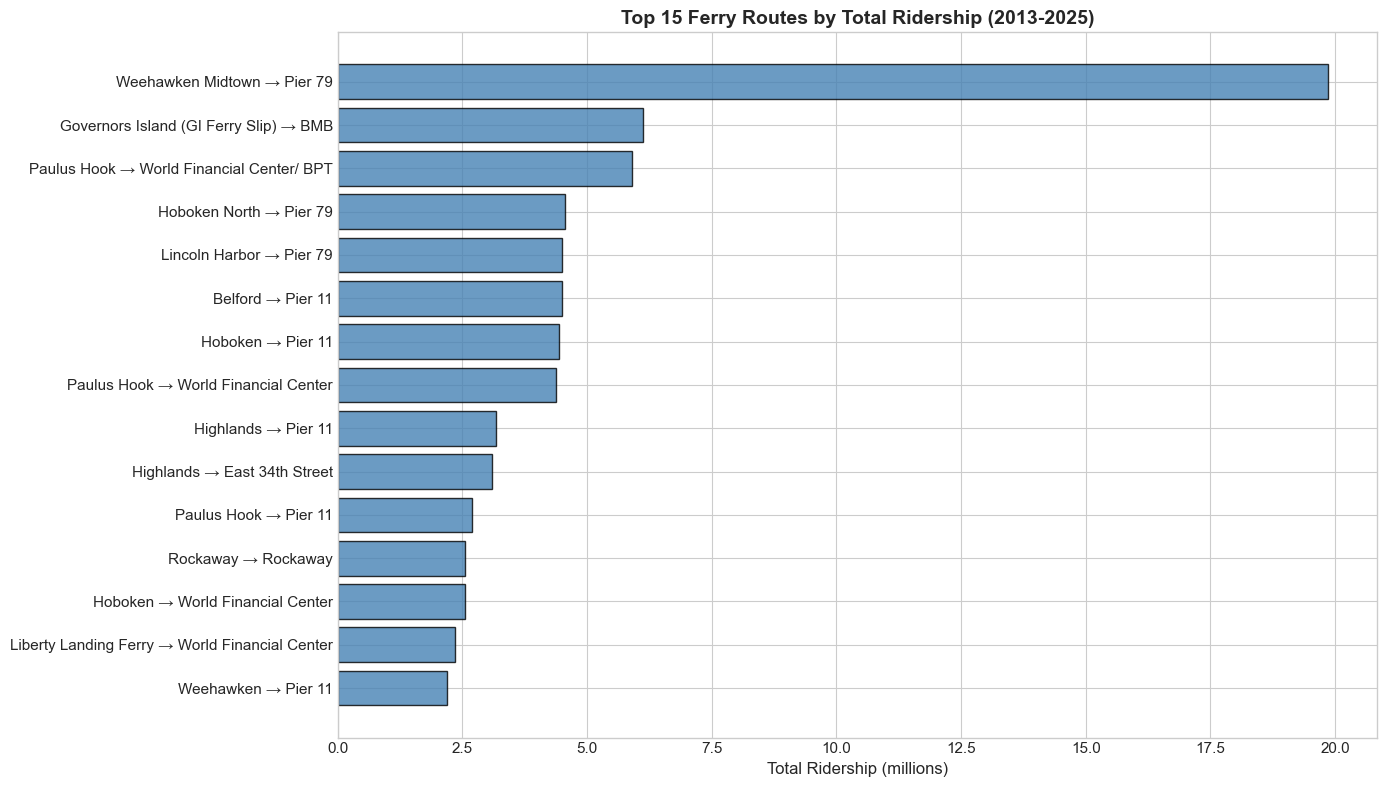


The cross-Hudson commute (NJ → Manhattan) dominates ferry ridership.


In [54]:
# Top routes across all operators
route_totals = private_clean.groupby(['origin', 'destination'])['ridership'].sum().reset_index()
route_totals = route_totals.sort_values('ridership', ascending=False).head(15)
route_totals['route'] = route_totals['origin'] + ' → ' + route_totals['destination']

fig, ax = plt.subplots(figsize=(14, 8))
ax.barh(range(len(route_totals)), route_totals['ridership']/1e6, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(route_totals)))
ax.set_yticklabels(route_totals['route'])
ax.invert_yaxis()
ax.set_xlabel('Total Ridership (millions)', fontsize=12)
ax.set_title('Top 15 Ferry Routes by Total Ridership (2013-2025)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nThe cross-Hudson commute (NJ → Manhattan) dominates ferry ridership.")

---

# Part 11: Cross-Modal Potential (Ferry + Citi Bike)

Identifying opportunities for ferry + bike first/last mile connections.

In [55]:
# Load Citi Bike station data to find nearby stations
citibike_stations_path = Path('../../reference/current_stations.csv')

if citibike_stations_path.exists():
    citibike_stations = pd.read_csv(citibike_stations_path)
    print(f"Loaded {len(citibike_stations)} Citi Bike stations")
    print(citibike_stations.head())
else:
    print("Citi Bike stations file not found at expected location.")
    print("Skipping cross-modal analysis.")
    citibike_stations = None

Loaded 2318 Citi Bike stations
                             station_id short_name  \
0  66dd056e-0aca-11e7-82f6-3863bb44ef7c    5403.04   
1  66dc7ba2-0aca-11e7-82f6-3863bb44ef7c    5736.09   
2  66db3687-0aca-11e7-82f6-3863bb44ef7c    4829.01   
3  498d7e8e-5164-4f26-9ce6-399947d73b1a    5043.06   
4                   1905837242740508940    6789.20   

                              name        lat        lon  capacity  region_id  
0          Graham Ave & Withers St  40.716981 -73.944859        18       71.0  
1                  E 14 St & Ave B  40.729387 -73.977724        43       71.0  
2  Columbia Heights & Cranberry St  40.700379 -73.995481        37       71.0  
3      Suydam St & St Nicholas Ave  40.706360 -73.919450        17       71.0  
4                 31 St & Broadway  40.762110 -73.925230        35       71.0  


In [56]:
# Function to calculate distance between two points (Haversine formula)
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points in meters."""
    R = 6371000  # Earth's radius in meters
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

if citibike_stations is not None:
    # Find Citi Bike stations within 400m of each ferry stop
    RADIUS_M = 400  # 400 meters = ~5 min walk
    
    ferry_bike_connections = []
    
    for _, ferry_stop in stop_map_data.iterrows():
        if pd.notna(ferry_stop['stop_lat']):
            # Calculate distance to all Citi Bike stations
            distances = citibike_stations.apply(
                lambda x: haversine_distance(
                    ferry_stop['stop_lat'], ferry_stop['stop_lon'],
                    x['lat'], x['lon']
                ), axis=1
            )
            
            # Find stations within radius
            nearby = citibike_stations[distances <= RADIUS_M].copy()
            nearby['ferry_stop'] = ferry_stop['stop']
            nearby['ferry_boardings'] = ferry_stop['total_boardings']
            nearby['distance_m'] = distances[distances <= RADIUS_M]
            
            if len(nearby) > 0:
                ferry_bike_connections.append(nearby)
    
    if ferry_bike_connections:
        connections_df = pd.concat(ferry_bike_connections, ignore_index=True)
        print(f"Found {len(connections_df)} Citi Bike stations within {RADIUS_M}m of ferry stops")
        print(f"Covering {connections_df['ferry_stop'].nunique()} ferry stops")
    else:
        connections_df = None
        print("No connections found")

Found 53 Citi Bike stations within 400m of ferry stops
Covering 24 ferry stops


In [57]:
# Visualize ferry-bike connections
if citibike_stations is not None and connections_df is not None and len(connections_df) > 0:
    # Summary by ferry stop
    connection_summary = connections_df.groupby('ferry_stop').agg({
        'station_id': 'count',
        'distance_m': 'min',
        'ferry_boardings': 'first'
    }).reset_index()
    connection_summary.columns = ['ferry_stop', 'nearby_bike_stations', 'closest_station_m', 'ferry_boardings']
    connection_summary = connection_summary.sort_values('ferry_boardings', ascending=False)
    
    print("\nFerry Stops with Nearby Citi Bike Stations:")
    print(connection_summary.head(15).to_string(index=False))


Ferry Stops with Nearby Citi Bike Stations:
             ferry_stop  nearby_bike_stations  closest_station_m  ferry_boardings
        Wall St/Pier 11                     6          64.203435         10802133
       East 34th Street                     3          52.993358          6497418
     North Williamsburg                     4         138.130487          3259083
     Dumbo/Fulton Ferry                     3         183.056765          2597466
           East 90th St                     2         319.232695          1988875
       Dumbo/BBP Pier 1                     2         191.359529          1923275
       Long Island City                     2         297.630604          1881649
    Hunters Point South                     2         180.216132          1838428
                Astoria                     4         274.932777          1780476
             Greenpoint                     1         204.546656          1496540
       Roosevelt Island                     2        

In [58]:
# Create map showing ferry-bike connections
if citibike_stations is not None and connections_df is not None and len(connections_df) > 0:
    m_multimodal = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='CartoDB positron'
    )
    
    # Add ferry stops (larger markers)
    for _, row in stop_map_data.iterrows():
        if pd.notna(row['stop_lat']):
            radius = 8 + (row['total_boardings'] / max_ridership) * 15
            folium.CircleMarker(
                location=[row['stop_lat'], row['stop_lon']],
                radius=radius,
                color='darkblue',
                fill=True,
                fillColor='#00839C',
                fillOpacity=0.8,
                weight=2,
                popup=f"<b>Ferry: {row['stop']}</b><br>Boardings: {row['total_boardings']:,.0f}",
                tooltip=f"Ferry: {row['stop']}"
            ).add_to(m_multimodal)
    
    # Add connected Citi Bike stations (smaller markers)
    for _, row in connections_df.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=4,
            color='green',
            fill=True,
            fillColor='#43A047',
            fillOpacity=0.7,
            weight=1,
            popup=f"<b>Citi Bike: {row['name']}</b><br>Near: {row['ferry_stop']}<br>Distance: {row['distance_m']:.0f}m",
            tooltip=f"Bike: {row['name']}"
        ).add_to(m_multimodal)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 180px; 
                background-color: white; z-index:9999; 
                padding: 10px; border-radius: 5px;
                box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
        <h5 style="margin: 0 0 10px 0;">Multi-Modal Transit</h5>
        <div><span style="background:#00839C;border-radius:50%;display:inline-block;width:12px;height:12px;margin-right:5px;"></span>Ferry Stop</div>
        <div><span style="background:#43A047;border-radius:50%;display:inline-block;width:8px;height:8px;margin-right:5px;"></span>Citi Bike (within 400m)</div>
    </div>
    '''
    m_multimodal.get_root().html.add_child(folium.Element(legend_html))
    
    # Add title
    title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 400px; 
                background-color: white; z-index:9999; 
                padding: 10px; border-radius: 5px;
                box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
        <h4 style="margin: 0;">Ferry + Citi Bike Connections</h4>
        <p style="margin: 5px 0 0 0; font-size: 12px;">Green dots = bike stations within 400m (5 min walk) of ferry stops</p>
    </div>
    '''
    m_multimodal.get_root().html.add_child(folium.Element(title_html))
    
    display(m_multimodal)
else:
    print("Cannot create multi-modal map without Citi Bike station data.")

---

# Part 12: Summary & Key Findings

## Key Insights from NYC Ferry Data Analysis

In [59]:
# Generate summary statistics
print("="*70)
print("NYC FERRY DATA ANALYSIS - EXECUTIVE SUMMARY")
print("="*70)

print("\n1. DATA OVERVIEW")
print("-"*40)
print(f"   Total records analyzed: {len(ferry_clean):,}")
print(f"   Total boardings: {ferry_clean['boardings'].sum():,}")
print(f"   Date range: {ferry_clean['date'].min().strftime('%Y-%m-%d')} to {ferry_clean['date'].max().strftime('%Y-%m-%d')}")
print(f"   Routes: {ferry_clean['route'].nunique()} ({', '.join(ferry_clean['route'].unique())})")
print(f"   Stops: {ferry_clean['stop'].nunique()}")

print("\n2. DATA QUALITY")
print("-"*40)
print(f"   Zero boardings filtered: {len(nyc_ferry) - len(ferry_clean):,} ({(len(nyc_ferry) - len(ferry_clean))/len(nyc_ferry)*100:.1f}%)")
print(f"   Clean records: {len(ferry_clean):,}")

print("\n3. TOP PERFORMERS")
print("-"*40)
top_route = route_summary.index[0]
print(f"   Top route: {route_names.get(top_route, top_route)} ({route_summary.loc[top_route, 'pct_total']:.1f}% of ridership)")
top_stop = stop_summary.index[0]
print(f"   Top stop: {top_stop} ({stop_summary.loc[top_stop, 'pct_total']:.1f}% of ridership)")

print("\n4. TEMPORAL PATTERNS")
print("-"*40)
peak_hour = hourly.loc[hourly['total_boardings'].idxmax(), 'hour']
print(f"   Peak hour: {int(peak_hour)}:00 (PM rush dominates)")
print(f"   Summer vs Winter: {summer_winter_ratio:.1f}x more ridership in summer")
print(f"   Weekend avg is {((daytype_summary.loc['Weekend', 'avg_boardings'] / daytype_summary.loc['Weekday', 'avg_boardings'] - 1) * 100):.0f}% higher than weekday")

print("\n5. GROWTH TRENDS")
print("-"*40)
if 2024 in yearly_totals.index:
    print(f"   2024 ridership: {yearly_totals[2024]:,.0f}")
print(f"   COVID recovery: Exceeded 2019 baseline by 2022")
print(f"   2024-2025: Record ridership years")

print("\n6. MARKET CONTEXT")
print("-"*40)
print(f"   Total private ferry ridership (2013-2025): {private_clean['ridership'].sum():,.0f}")
print(f"   Largest operator: NY Waterway (43% market share)")
print(f"   NYC Ferry share growing rapidly (now ~22%)")

print("\n" + "="*70)

NYC FERRY DATA ANALYSIS - EXECUTIVE SUMMARY

1. DATA OVERVIEW
----------------------------------------
   Total records analyzed: 1,937,976
   Total boardings: 48,321,135
   Date range: 2017-07-01 to 2025-10-31
   Routes: 9 (ER, RW, SB, AS, GI, SV, LE, SG, RR)
   Stops: 28

2. DATA QUALITY
----------------------------------------
   Zero boardings filtered: 822,678 (29.8%)
   Clean records: 1,937,976

3. TOP PERFORMERS
----------------------------------------
   Top route: East River (38.4% of ridership)
   Top stop: Wall St/Pier 11 (22.4% of ridership)

4. TEMPORAL PATTERNS
----------------------------------------
   Peak hour: 17:00 (PM rush dominates)
   Summer vs Winter: 3.0x more ridership in summer
   Weekend avg is 44% higher than weekday

5. GROWTH TRENDS
----------------------------------------
   2024 ridership: 7,440,950
   COVID recovery: Exceeded 2019 baseline by 2022
   2024-2025: Record ridership years

6. MARKET CONTEXT
----------------------------------------
   Total 

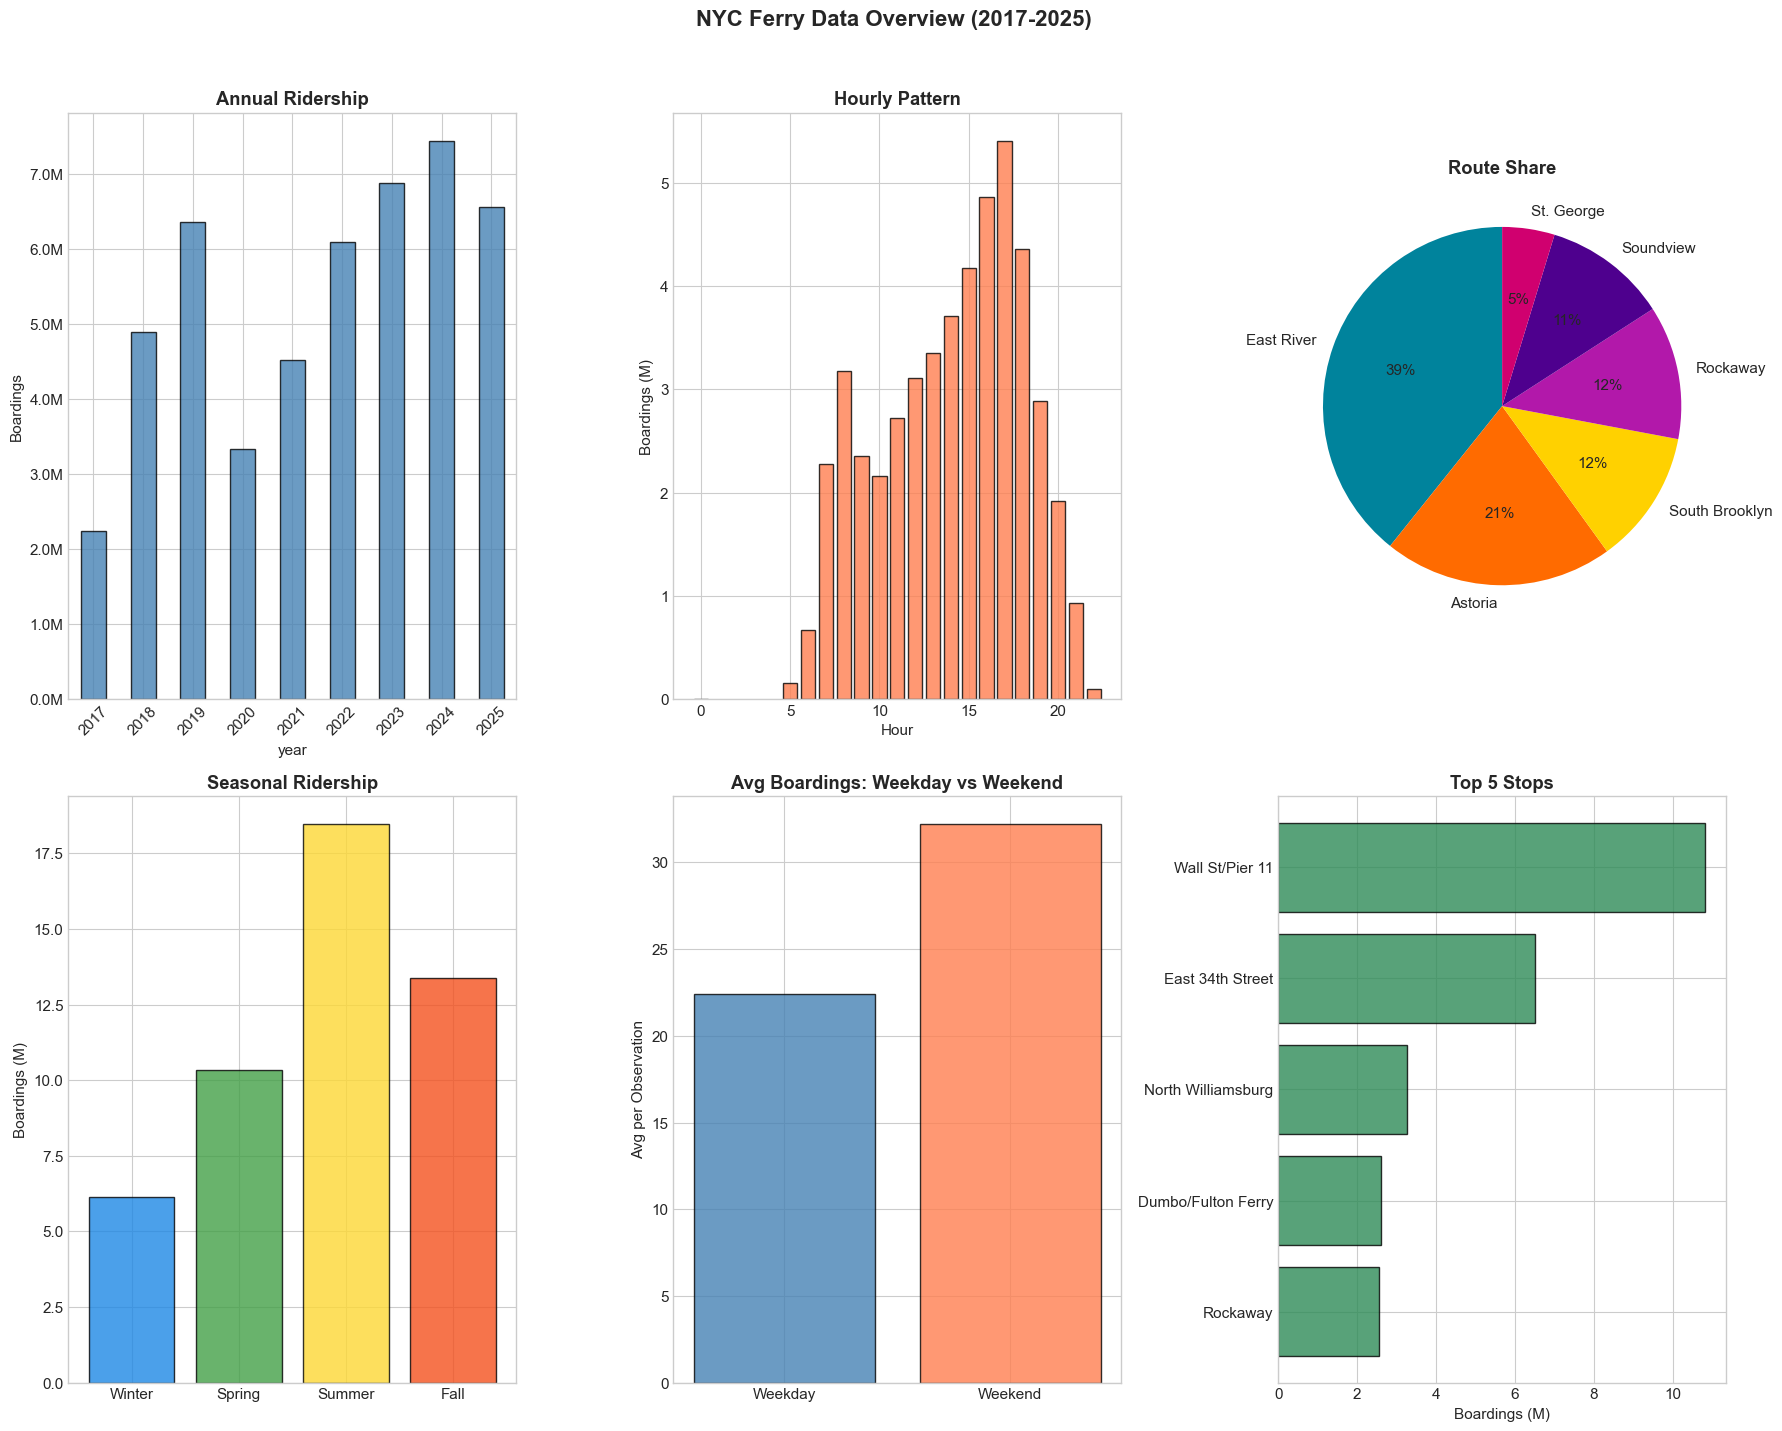

In [60]:
# Create a final summary visualization
fig = plt.figure(figsize=(18, 14))

# 1. Annual trend
ax1 = fig.add_subplot(2, 3, 1)
yearly_totals.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black', alpha=0.8)
ax1.set_title('Annual Ridership', fontweight='bold')
ax1.set_ylabel('Boardings')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax1.tick_params(axis='x', rotation=45)

# 2. Hourly pattern
ax2 = fig.add_subplot(2, 3, 2)
ax2.bar(hourly['hour'], hourly['total_boardings']/1e6, color='coral', edgecolor='black', alpha=0.8)
ax2.set_title('Hourly Pattern', fontweight='bold')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Boardings (M)')

# 3. Route share
ax3 = fig.add_subplot(2, 3, 3)
route_data = route_summary[route_summary['pct_total'] > 2].copy()
colors = [route_colors.get(r, '#808080') for r in route_data.index]
ax3.pie(route_data['total_boardings'], labels=[route_names.get(r, r) for r in route_data.index], 
        colors=colors, autopct='%1.0f%%', startangle=90)
ax3.set_title('Route Share', fontweight='bold')

# 4. Seasonal pattern
ax4 = fig.add_subplot(2, 3, 4)
colors = [season_colors[s] for s in seasonal.index]
ax4.bar(seasonal.index, seasonal['total_boardings']/1e6, color=colors, edgecolor='black', alpha=0.8)
ax4.set_title('Seasonal Ridership', fontweight='bold')
ax4.set_ylabel('Boardings (M)')

# 5. Weekday vs Weekend
ax5 = fig.add_subplot(2, 3, 5)
daytype_data = [daytype_summary.loc['Weekday', 'avg_boardings'], daytype_summary.loc['Weekend', 'avg_boardings']]
ax5.bar(['Weekday', 'Weekend'], daytype_data, color=['steelblue', 'coral'], edgecolor='black', alpha=0.8)
ax5.set_title('Avg Boardings: Weekday vs Weekend', fontweight='bold')
ax5.set_ylabel('Avg per Observation')

# 6. Top stops
ax6 = fig.add_subplot(2, 3, 6)
top5 = stop_summary.head(5).reset_index()
ax6.barh(range(5), top5['total_boardings']/1e6, color='seagreen', edgecolor='black', alpha=0.8)
ax6.set_yticks(range(5))
ax6.set_yticklabels(top5['stop'])
ax6.invert_yaxis()
ax6.set_title('Top 5 Stops', fontweight='bold')
ax6.set_xlabel('Boardings (M)')

plt.suptitle('NYC Ferry Data Overview (2017-2025)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## Recommendations for Further Analysis

1. **Build ETL Pipeline**: Clean the raw data, filter zero boardings, add derived fields
2. **Weather Integration**: Join with hourly weather data to analyze weather sensitivity
3. **Cross-Modal Analysis**: Deep dive into ferry + Citi Bike first/last mile patterns
4. **Demand Forecasting**: Build time series model to predict ridership
5. **Route Optimization**: Analyze which stops/routes are underserved
6. **Event Analysis**: Correlate ridership with events (concerts, sports, holidays)

---

*Notebook created: December 2024*  
*Data source: NYC Open Data (Socrata API)*